In [1]:
#%load_ext autoreload
#%autoreload 2

# Configuring the Application

First, let’s import the necessary dependencies

- panel for dashboard
- json for reading data, datetime for date and time manipulation
- numpy and pandas for data analysis
- hvplot, matplotlib, and seaborn for data display and plotting

In [2]:
import datetime
import json
import math
from collections import Counter, defaultdict
from pprint import pp

# data analysis
import numpy as np
import pandas as pd

# dashboard
import panel as pn

# plotting
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib import cm

Next, we’ll import the Panel JavaScript dependencies using `pn.extension(...)`.

The `'ipywidgets'` extension is recommended to use with `Matplotlib` pane in the Panel documentation.

For a visually appealing and responsive user experience, we’ll set the `design` to `"material"` and the `sizing_mode` to `"stretch_width"`:

In [3]:
#pn.extension('ipywidgets', design="material", sizing_mode="stretch_width")
pn.extension('ipywidgets', design="material", sizing_mode='fixed')

# Fetching the Data

The annotation data was generated from the `tensorflow` repository with the following command:
```commandline
time diff-annotate from-repo ...
```
by running `dvc repro` command ("annotate" stage).

-----

The statistics in `'tensorflow.timeline.json'` file were generated with the following command:

```commandline
time diff-gather-stats \
    --annotations-dir='' \
    timeline \
    ...
```
by running `dvc repro` command ("timeline" stage).

The statistics in `'tensorflow.timeline.purpose-to-type.json'` file were generated with the following command:

```commandline
diff-gather-stats \
    --annotations-dir='' \
    timeline \
    --purpose-to-annotation=data \
    --purpose-to-annotation=documentation \
    --purpose-to-annotation=markup \
    --purpose-to-annotation=other \
    --purpose-to-annotation=project \
    --purpose-to-annotation=test \
    ...
```
by running `dvc repro` command ("timeline.putpose-to-type" stage).

In [4]:
TOP_DIR = '../../'
DATASET_DIR = f'{TOP_DIR}data/examples/stats'
JSON_FILE = 'tensorflow.timeline.purpose-to-type.json'

We’ll speed up our application by caching (`@pn.cache`) the data across users

In [5]:
@pn.cache
def get_timeline_data():
    with open(f'{DATASET_DIR}/{JSON_FILE}', mode='r') as json_fp:
        return json.load(json_fp)

In [6]:
timeline_data = get_timeline_data()
type(timeline_data)

dict

There is only one dataset: `'tensorflow'`

In [7]:
timeline_data.keys()

dict_keys(['tensorflow'])

In [8]:
tf_timeline_data = timeline_data['tensorflow']

Create `DataFrame` out of timeline data

In [9]:
tf_timeline_df = pd.DataFrame.from_records(tf_timeline_data)
tf_timeline_df

,bug_id,patch_id,file_names,language:Starlark,type:programming,purpose:project,+:count,+:type.project,+:purpose.project,author.timestamp,...,language:Cython,language:Protocol Buffer,language:MLIR,language:HTML,type:markup,purpose:markup,+:type.markup,+:purpose.markup,-:type.markup,-:purpose.markup
0,yong.tang,cf1429707d68edb22cd861ce900d0ec4600668e5.json,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.527102e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yong.tang,66803c1fca4d178d6ba8f4c96073efaed8541d59.json,1.0,NaN,1.0,NaN,22.0,NaN,NaN,1.566144e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yong.tang,771a8060e8eea386d75ace3d08794f3b967db564.json,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.531462e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yong.tang,caf1e0e307efe8746de167dcd0f2b226ac7cbea9.json,1.0,NaN,1.0,NaN,8.0,NaN,NaN,1.664984e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,yong.tang,f6940f2195b5f3e017ab5b8618d1a6fd5d6671ac.json,1.0,NaN,1.0,NaN,4.0,NaN,NaN,1.594938e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ezhulenev,46cf49d55bda33fefa7681631f01c7d4c9eafcd6.json,14.0,2.0,12.0,2.0,1711.0,117.0,117.0,1.698380e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3340,ezhulenev,98aa5d0be743aca99992c0e58fc2980b332594bb.json,3.0,NaN,2.0,NaN,10.0,NaN,NaN,1.582264e+09,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3341,ezhulenev,422bd16858138f711c2672cd8a8b98ac07d5a18c.json,4.0,1.0,4.0,1.0,27.0,1.0,1.0,1.717111e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342,ezhulenev,a4e0c1111c3640366a5d7593444a31227a6b2811.json,1.0,NaN,1.0,NaN,7.0,NaN,NaN,1.711592e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploring the Parameter Space

Let’s create some Panel slider widgets to explore the range of parameter values:

## Repository (fake)

In [10]:
repos_widget = pn.widgets.Select(name="repository", value="tensorflow", options=["tensorflow"], disabled=True)

In [11]:
display(repos_widget)

Select(design=<class 'panel.theme.materi..., disabled=True, name='repository', options=['tensorflow'], value='tensorflow')

## Authors

In [12]:
authors = tf_timeline_df['bug_id'].unique()

In [13]:
authors_widget = pn.widgets.Select(name="author", value=authors[0], options=list(authors))

Test that the `authors_widget` works:

In [14]:
display(authors_widget)

Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')

In [15]:
authors_counts = tf_timeline_df['bug_id'].value_counts().to_dict()
authors_counts

{'ezhulenev': 1896, 'yong.tang': 1448}

In [16]:
authors_radio_box = pn.widgets.RadioBoxGroup(
    name='choose author', value=authors[0], inline=False,
    options={
        f"{author:14s}: {authors_counts[author]:6d} commits": author
        for author in authors_counts.keys()
    }
)

In [17]:
display(authors_radio_box)

RadioBoxGroup(design=<class 'panel.theme.materi..., name='choose author', options={'ezhulenev     :   1896 c...}, value='yong.tang')

## Resample rate

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [18]:
pd.DataFrame.from_records(
    columns=['Alias', 'Description'],
    data=[
        ('B', 'business day frequency'),
        ('C', 'custom business day frequency'),
        ('D', 'calendar day frequency'),
        ('W', 'weekly frequency'),
        ('ME', 'month end frequency'),
        ('SME', 'semi-month end frequency (15th and end of month)'),
        ('BME', 'business month end frequency'),
        ('CBME', 'custom business month end frequency'),
        ('MS', 'month start frequency'),
        ('SMS', 'semi-month start frequency (1st and 15th)'),
        ('BMS', 'business month start frequency'),
        ('CBMS', 'custom business month start frequency'),
        ('QE', 'quarter end frequency'),
        ('BQE', 'business quarter end frequency'),
        ('QS', 'quarter start frequency'),
        ('BQS', 'business quarter start frequency'),
        ('YE', 'year end frequency'),
        ('BYE', 'business year end frequency'),
        ('YS', 'year start frequency'),
        ('BYS', 'business year start frequency'),
        ('h', 'hourly frequency'),
        ('bh', 'business hour frequency'),
        ('cbh', 'custom business hour frequency'),
        ('min', 'minutely frequency'),
        ('s', 'secondly frequency'),
        ('ms', 'milliseconds'),
        ('us', 'microseconds'),
        ('ns', 'nanoseconds'),
    ]
)

,Alias,Description
0,B,business day frequency
1,C,custom business day frequency
2,D,calendar day frequency
3,W,weekly frequency
4,ME,month end frequency
5,SME,semi-month end frequency (15th and end of month)
6,BME,business month end frequency
7,CBME,custom business month end frequency
8,MS,month start frequency
9,SMS,semi-month start frequency (1st and 15th)


In [19]:
# mapping form display name to alias
time_series_frequencies = {
    'calendar day frequency': 'D',
    'weekly frequency': 'W',
    'semi-month end frequency (15th and end of month)': 'SME',
    'month end frequency': 'ME',
    'quarter end frequency': 'QE',
}
pp(time_series_frequencies)

{'calendar day frequency': 'D',
 'weekly frequency': 'W',
 'semi-month end frequency (15th and end of month)': 'SME',
 'month end frequency': 'ME',
 'quarter end frequency': 'QE'}


In [20]:
resample_rule_widget = pn.widgets.Select(name="frequency", value='ME', options=time_series_frequencies)
display(resample_rule_widget)

Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')

## Line type, or file purpose

In [21]:
all_possible_pm_col_basenames = sorted([col[2:] for col in tf_timeline_df.columns if col.startswith('+:')])
all_possible_pm_col_basenames

['count',
 'purpose.data',
 'purpose.documentation',
 'purpose.markup',
 'purpose.other',
 'purpose.programming',
 'purpose.project',
 'purpose.test',
 'type.code',
 'type.data',
 'type.documentation',
 'type.markup',
 'type.other',
 'type.project',
 'type.test']

In [22]:
all_possible_pm_col_perc_basenames = [f"{col} [%]" for col in all_possible_pm_col_basenames if col != 'count']
all_possible_pm_col_perc_basenames

['purpose.data [%]',
 'purpose.documentation [%]',
 'purpose.markup [%]',
 'purpose.other [%]',
 'purpose.programming [%]',
 'purpose.project [%]',
 'purpose.test [%]',
 'type.code [%]',
 'type.data [%]',
 'type.documentation [%]',
 'type.markup [%]',
 'type.other [%]',
 'type.project [%]',
 'type.test [%]']

In [23]:
column_base_widget = pn.widgets.Select(name="column [base]name", value='type.code',
                                       options=[*all_possible_pm_col_basenames, *all_possible_pm_col_perc_basenames],
                                       disabled_options=all_possible_pm_col_perc_basenames)
display(column_base_widget)

Select(design=<class 'panel.theme.materi..., disabled_options=['purpose.data [%]', ...], name='column [base]name', options=['count', 'purpose.data', ...], value='type.code')

In [24]:
pn.Column(
    pn.Row(pn.pane.Str("autoscale"), pn.widgets.Switch(name="autoscale", value=True)),
    #pn.widgets.Toggle(name='autoscale', button_type='primary', value=True),
    pn.widgets.Checkbox(name='autoscale', value=True),
    pn.widgets.ToggleIcon(name="autoscale", size="2em", description="automatically set yscale",
                          active_icon="arrows-move-vertical", icon="minus-vertical",
                          value=True),
    pn.widgets.ToggleIcon(name="autoscale", size="2em", description="automatically set yscale",
                          icon="zoom-in-area",
                          value=True),
)

Column(design=<class 'panel.theme.materi...)
    [0] Row(design=<class 'panel.theme.materi...)
        [0] Str(str, design=<class 'panel.theme.materi...)
        [1] Switch(design=<class 'panel.theme.materi..., name='autoscale', value=True)
    [1] Checkbox(design=<class 'panel.theme.materi..., name='autoscale', value=True)
    [2] ToggleIcon(active_icon='arrows-move-vertical', description='automatically s..., design=<class 'panel.theme.materi..., icon='minus-vertical', name='autoscale', size='2em', value=True)
    [3] ToggleIcon(description='automatically s..., design=<class 'panel.theme.materi..., icon='zoom-in-area', name='autoscale', size='2em', value=True)

In [25]:
autoscale_widget = pn.widgets.Checkbox(name='autoscale column [base]name', value=True)
autoscale_widget

Checkbox(design=<class 'panel.theme.materi..., name='autoscale column [..., value=True)

In [26]:
pm_col_widget = pn.Row(
    pn.FlexBox(
        column_base_widget,
        # spacer? divider?
        autoscale_widget,
        align_items='baseline',
    ),
)
pm_col_widget

Row(design=<class 'panel.theme.materi...)
    [0] FlexBox(align_items='baseline', design=<class 'panel.theme.materi..., objects=[Select(design=<class 'pan...], sizing_mode='stretch_width')

## Aggregation function

In [27]:
aggregation_functions = [
    'sum',
    'mean',
    'median',
    'max',
    'min',
    'std',
]
aggregation_functions

['sum', 'mean', 'median', 'max', 'min', 'std']

In [28]:
agg_func_widget = pn.widgets.Select(name="aggregation function", value=aggregation_functions[0], options=aggregation_functions)
display(agg_func_widget)

Select(design=<class 'panel.theme.materi..., name='aggregation function', options=['sum', 'mean', ...], value='sum')

## Histogram options

In [29]:
bin_width_widget = pn.widgets.EditableIntSlider(name="bin width", value=3, start=1, fixed_start=1, end=25, margin=(-5, 10))
bin_width_widget

EditableIntSlider(design=<class 'panel.theme.materi..., end=25, fixed_start=1, margin=(-5, 10), name='bin width', start=1, value=3, width=300)

In [30]:
max_value_widget = pn.widgets.EditableIntSlider(name="max value", value=100, start=10, fixed_start=1, end=500, step=5, margin=(-2, 10))
max_value_widget

EditableIntSlider(design=<class 'panel.theme.materi..., end=500, fixed_start=1, margin=(-2, 10), name='max value', start=10, step=5, value=100, width=300)

In [31]:
hist_widget = pn.WidgetBox('histogram', bin_width_widget, max_value_widget, disabled=False)
hist_widget

WidgetBox(design=<class 'panel.theme.materi...)
    [0] Markdown(str, design=<class 'panel.theme.materi...)
    [1] EditableIntSlider(design=<class 'panel.theme.materi..., end=25, fixed_start=1, margin=(-5, 10), name='bin width', start=1, value=3, width=300)
    [2] EditableIntSlider(design=<class 'panel.theme.materi..., end=500, fixed_start=1, margin=(-2, 10), name='max value', start=10, step=5, value=100, width=300)

## TODO

- `DateRangeSlider` widget coupled with `DatetimeRangePicker` to select date range; default is from given author, full range is for all authors available
- _maybe_ `IntSlider` widget to select figure size (or two sliders, one for height, one for width)
- _maybe_ `FileSelector`, `FileDropper`, or `FileInput` widget to provide `*.timeline*.json` file to analyze

# Changing the look

This includes set of configuration values to change the look of the application, and set of widgets to control it

## Figsize

In [32]:
from bokeh.models.formatters import PrintfTickFormatter

In [33]:
figsize_params = dict(start=1, fixed_start=1, end=8, fixed_end=10, step=0.05, value=5,
                      format=PrintfTickFormatter(format='%.2f in'),
                      margin=(-5, 10))

figsize_x_slider = pn.widgets.EditableFloatSlider(name='size.x', **figsize_params)
figsize_y_slider = pn.widgets.EditableFloatSlider(name='size.y', **figsize_params)  # orientation='vertical' does not work (???)
figsize_widget = pn.WidgetBox('figsize', figsize_x_slider, figsize_y_slider, disabled=True)

figsize_widget

WidgetBox(design=<class 'panel.theme.materi..., disabled=True)
    [0] Markdown(str, design=<class 'panel.theme.materi...)
    [1] EditableFloatSlider(design=<class 'panel.theme.materi..., disabled=True, end=8, fixed_end=10, fixed_start=1, format=PrintfTickFormatter(id='a5..., margin=(-5, 10), name='size.x', start=1, step=0.05, value=5, width=300)
    [2] EditableFloatSlider(design=<class 'panel.theme.materi..., disabled=True, end=8, fixed_end=10, fixed_start=1, format=PrintfTickFormatter(id='a5..., margin=(-5, 10), name='size.y', start=1, step=0.05, value=5, width=300)

There were some problems passing `figsize` to the plot function; using `figsize_x_slider.value` helped, but it still does not work, even with `fixed_aspect=False`.

Currently this widget is bound, but it is disabled - because it does not work.

In [34]:
figsize_y_slider

EditableFloatSlider(design=<class 'panel.theme.materi..., disabled=True, end=8, fixed_end=10, fixed_start=1, format=PrintfTickFormatter(id='a5..., margin=(-5, 10), name='size.y', start=1, step=0.05, value=5, width=300)

## Plot styling (WIP)

See https://panel.holoviz.org/how_to/styling/matplotlib.html

In [35]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

## Matplotlib pane formatting

In [36]:
plot_width = pn.widgets.IntSlider(name='width', start=100, end=1200, step=50, value=500)
plot_width

IntSlider(design=<class 'panel.theme.materi..., end=1200, name='width', start=100, step=50, value=500)

In [37]:
plot_sizing_mode = pn.widgets.Select(name='sizing_mode', options=['fixed', 'stretch_width'], value='fixed', disabled=True)
plot_sizing_mode

Select(design=<class 'panel.theme.materi..., disabled=True, name='sizing_mode', options=['fixed', 'stretch_width']...], value='fixed')

In [38]:
plot_sizing_mode.rx()

Testing some tricks with `plot_width` and `plot_sizing_mode`, and `*.rx()`

In [39]:
plot_width.rx() if plot_sizing_mode.rx() == 'xxx' else None

In [40]:
plot_sizing_mode.rx() == 'xxx'

The combination of `plot_sizing_mode.rx()` and `plot_width.rx() if plot_sizing_mode.rx() == 'fixed' else None` does not work, but setting sizing mode to `"fixed"` unconditionally work (???)

In [41]:
plot_format = pn.widgets.Select(name='format', options=['png', 'svg'], value='png')
plot_format

Select(design=<class 'panel.theme.materi..., name='format', options=['png', 'svg'], value='png')

## Page styling and theming (WIP)

Size of the side panel with widgets

In [42]:
sidebar_width = pn.widgets.IntSlider(name='sidebar width', start=100, end=600, step=10, value=370)
sidebar_width.rx()

**NOTE:**

Unfortunately, it is not as simple as using `sidebar_width=sidebar_width.rx(),` when creating and configuring the template,
because it results in the following error:

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[108], line 4
      1 pn.template.MaterialTemplate(
      2     site="diffannotator",
      3     title="Examining Timeline",
----> 4     sidebar_width=str(sidebar_width.rx()),
      5     sidebar=[
      6         repos_widget,  # disabled, and UNBOUND!
      7         authors_widget,
      8         #authors_radio_box,
[...]
     42 ).servable(); # The ; is needed in the notebook to not display the template. Its not needed in a script

TypeError: __str__ returned non-string (type rx)
```

# Process data

In [43]:
pm_count_cols = [col for col in tf_timeline_df.columns if col.startswith('+:') or col.startswith('-:')]
pm_count_cols.sort(key=lambda s: s[2:]+('0' if s[0] == '-' else '1'))
pm_count_cols

['-:count',
 '+:count',
 '-:purpose.data',
 '+:purpose.data',
 '-:purpose.documentation',
 '+:purpose.documentation',
 '-:purpose.markup',
 '+:purpose.markup',
 '-:purpose.other',
 '+:purpose.other',
 '-:purpose.programming',
 '+:purpose.programming',
 '-:purpose.project',
 '+:purpose.project',
 '-:purpose.test',
 '+:purpose.test',
 '-:type.code',
 '+:type.code',
 '-:type.data',
 '+:type.data',
 '-:type.documentation',
 '+:type.documentation',
 '-:type.markup',
 '+:type.markup',
 '-:type.other',
 '+:type.other',
 '-:type.project',
 '+:type.project',
 '-:type.test',
 '+:type.test']

In [44]:
diff_x_cols = [col for col in tf_timeline_df.columns if col.startswith('diff.')]
diff_x_cols

['diff.n_files',
 'diff.hunk_span_src',
 'diff.hunk_span_dst',
 'diff.n_hunks',
 'diff.n_lines_added',
 'diff.n_lines_all',
 'diff.n_add',
 'diff.n_groups',
 'diff.patch_size',
 'diff.hunk_spread_src',
 'diff.hunk_spread_dst',
 'diff.groups_spread',
 'diff.n_lines_removed',
 'diff.n_rem',
 'diff.n_mod',
 'diff.spread_inner',
 'diff.n_binary_files']

## Add 'n_commits' column

Before resampling, each row correspons to a single commit

In [45]:
tf_timeline_df['n_commits'] = 1

## Convert timestamps to `pd.Timestamp` / `datetime64[ns]`

First, drop any rows where there is no information about author/committer datetime

In [46]:
tf_timeline_df.shape

(3344, 95)

In [47]:
# just in case, if there are any problems with timestamp fields
tf_timeline_df.dropna(inplace=True, subset=['author.timestamp', 'committer.timestamp'], how='any')

In [48]:
tf_timeline_df.shape

(3343, 95)

Create `pd.Timestamp` columns out of timestamp; because they all have to be in the same timezone, use UTC timezone

In [49]:
tf_timeline_df['author.date'] = tf_timeline_df[['author.timestamp', 'author.tz_info']].apply(
    lambda x: pd.Timestamp.fromtimestamp(x['author.timestamp'], tz='UTC'),
axis='columns').astype('datetime64[ns, UTC]')

tf_timeline_df['committer.date'] = tf_timeline_df[['committer.timestamp', 'committer.tz_info']].apply(
    lambda x: pd.Timestamp.fromtimestamp(x['committer.timestamp'], tz='UTC'),
axis='columns').astype('datetime64[ns, UTC]')

tf_timeline_df[['bug_id', 'patch_id', 'author.date', 'author.timestamp', 'author.tz_info']]

,bug_id,patch_id,author.date,author.timestamp,author.tz_info
0,yong.tang,cf1429707d68edb22cd861ce900d0ec4600668e5.json,2018-05-23 19:06:56+00:00,1.527102e+09,+0000
1,yong.tang,66803c1fca4d178d6ba8f4c96073efaed8541d59.json,2019-08-18 15:53:36+00:00,1.566144e+09,+0000
2,yong.tang,771a8060e8eea386d75ace3d08794f3b967db564.json,2018-07-13 06:04:32+00:00,1.531462e+09,+0000
3,yong.tang,caf1e0e307efe8746de167dcd0f2b226ac7cbea9.json,2022-10-05 15:39:23+00:00,1.664984e+09,+0000
4,yong.tang,f6940f2195b5f3e017ab5b8618d1a6fd5d6671ac.json,2020-07-16 22:13:26+00:00,1.594938e+09,+0000
...,...,...,...,...,...
3339,ezhulenev,46cf49d55bda33fefa7681631f01c7d4c9eafcd6.json,2023-10-27 04:17:17+00:00,1.698380e+09,-0700
3340,ezhulenev,98aa5d0be743aca99992c0e58fc2980b332594bb.json,2020-02-21 05:40:12+00:00,1.582264e+09,-0800
3341,ezhulenev,422bd16858138f711c2672cd8a8b98ac07d5a18c.json,2024-05-30 23:12:22+00:00,1.717111e+09,-0700
3342,ezhulenev,a4e0c1111c3640366a5d7593444a31227a6b2811.json,2024-03-28 02:16:10+00:00,1.711592e+09,-0700


## Groupby / resample

In [50]:
pm_count_cols

['-:count',
 '+:count',
 '-:purpose.data',
 '+:purpose.data',
 '-:purpose.documentation',
 '+:purpose.documentation',
 '-:purpose.markup',
 '+:purpose.markup',
 '-:purpose.other',
 '+:purpose.other',
 '-:purpose.programming',
 '+:purpose.programming',
 '-:purpose.project',
 '+:purpose.project',
 '-:purpose.test',
 '+:purpose.test',
 '-:type.code',
 '+:type.code',
 '-:type.data',
 '+:type.data',
 '-:type.documentation',
 '+:type.documentation',
 '-:type.markup',
 '+:type.markup',
 '-:type.other',
 '+:type.other',
 '-:type.project',
 '+:type.project',
 '-:type.test',
 '+:type.test']

In [51]:
diff_x_cols

['diff.n_files',
 'diff.hunk_span_src',
 'diff.hunk_span_dst',
 'diff.n_hunks',
 'diff.n_lines_added',
 'diff.n_lines_all',
 'diff.n_add',
 'diff.n_groups',
 'diff.patch_size',
 'diff.hunk_spread_src',
 'diff.hunk_spread_dst',
 'diff.groups_spread',
 'diff.n_lines_removed',
 'diff.n_rem',
 'diff.n_mod',
 'diff.spread_inner',
 'diff.n_binary_files']

In [52]:
#@pn.cache
def resample_timeline(author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum') -> pd.DataFrame:
    ## DEBUG
    #print(f"> resampling for {author} at sample rate '{resample_rate}' and agg_func '{agg_func}'")
    df = tf_timeline_df[tf_timeline_df['bug_id'] == author].resample(
        resample_rate,
        on='author.date'
    )[['n_commits', *pm_count_cols, *diff_x_cols]].agg(
        {col: agg_func if col in [*pm_count_cols, *diff_x_cols] else 'sum'  # excludes 'n_commits'
         for col in ['n_commits', *pm_count_cols, *diff_x_cols]},
        numeric_only=True
    )

    # to be possibly used for xlabel when plotting
    df['author.date(UTC)'] = df.index
    df['author.date(Y-m)'] = df.index.strftime('%Y-%m')

    # TODO: do it with dependencies / bound functions
    # NOTE: Panel specific !!!
    #column_base_widget.disabled_options = all_possible_pm_col_perc_basenames

    return df

Test that resampling works, before binding it to a widget

In [53]:
tf_timeline_selected_resampled_df = resample_timeline()
tf_timeline_selected_resampled_df.head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,diff.hunk_spread_src,diff.hunk_spread_dst,diff.groups_spread,diff.n_lines_removed,diff.n_rem,diff.n_mod,diff.spread_inner,diff.n_binary_files,author.date(UTC),author.date(Y-m)
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,362.0,2067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4722.0,4722.0,1725.0,101.0,37.0,64.0,124.0,0.0,2018-06-30 00:00:00+00:00,2018-06
2018-07-31 00:00:00+00:00,2,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,340.0,340.0,365.0,4.0,1.0,3.0,0.0,0.0,2018-07-31 00:00:00+00:00,2018-07
2018-08-31 00:00:00+00:00,2,14.0,543.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,113.0,113.0,131.0,14.0,7.0,7.0,3.0,0.0,2018-08-31 00:00:00+00:00,2018-08
2018-09-30 00:00:00+00:00,18,1363.0,4322.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9402.0,9402.0,3639.0,835.0,480.0,413.0,247.0,0.0,2018-09-30 00:00:00+00:00,2018-09
2018-10-31 00:00:00+00:00,16,1038.0,2633.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4395.0,4395.0,3695.0,122.0,133.0,107.0,134.0,0.0,2018-10-31 00:00:00+00:00,2018-10


In [54]:
tf_timeline_selected_resampled_df = resample_timeline(agg_func='mean')
tf_timeline_selected_resampled_df.head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,diff.hunk_spread_src,diff.hunk_spread_dst,diff.groups_spread,diff.n_lines_removed,diff.n_rem,diff.n_mod,diff.spread_inner,diff.n_binary_files,author.date(UTC),author.date(Y-m)
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,60.333333,258.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,674.571429,674.571429,215.625000,16.833333,9.250000,12.800000,41.333333,NaN,2018-06-30 00:00:00+00:00,2018-06
2018-07-31 00:00:00+00:00,2,2.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,170.000000,170.000000,182.500000,2.000000,1.000000,1.500000,NaN,NaN,2018-07-31 00:00:00+00:00,2018-07
2018-08-31 00:00:00+00:00,2,14.000000,271.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113.000000,113.000000,65.500000,14.000000,7.000000,7.000000,3.000000,NaN,2018-08-31 00:00:00+00:00,2018-08
2018-09-30 00:00:00+00:00,18,97.357143,240.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,626.800000,626.800000,202.166667,59.642857,48.000000,29.500000,16.466667,NaN,2018-09-30 00:00:00+00:00,2018-09
2018-10-31 00:00:00+00:00,16,79.846154,175.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,293.000000,293.000000,230.937500,9.384615,12.090909,8.916667,13.400000,NaN,2018-10-31 00:00:00+00:00,2018-10


In [55]:
tf_timeline_selected_resampled_df = resample_timeline(agg_func='median')
tf_timeline_selected_resampled_df.head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,diff.hunk_spread_src,diff.hunk_spread_dst,diff.groups_spread,diff.n_lines_removed,diff.n_rem,diff.n_mod,diff.spread_inner,diff.n_binary_files,author.date(UTC),author.date(Y-m)
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,32.0,196.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,212.0,212.0,25.0,20.0,7.5,9.0,48.0,NaN,2018-06-30 00:00:00+00:00,2018-06
2018-07-31 00:00:00+00:00,2,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,170.0,170.0,182.5,2.0,1.0,1.5,NaN,NaN,2018-07-31 00:00:00+00:00,2018-07
2018-08-31 00:00:00+00:00,2,14.0,271.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113.0,113.0,65.5,14.0,7.0,7.0,3.0,NaN,2018-08-31 00:00:00+00:00,2018-08
2018-09-30 00:00:00+00:00,18,48.0,114.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184.0,184.0,85.0,13.0,29.5,12.5,7.0,NaN,2018-09-30 00:00:00+00:00,2018-09
2018-10-31 00:00:00+00:00,16,35.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,300.0,300.0,139.5,5.0,3.0,4.0,7.5,NaN,2018-10-31 00:00:00+00:00,2018-10


## Percentages

In [56]:
pm_count_cols

['-:count',
 '+:count',
 '-:purpose.data',
 '+:purpose.data',
 '-:purpose.documentation',
 '+:purpose.documentation',
 '-:purpose.markup',
 '+:purpose.markup',
 '-:purpose.other',
 '+:purpose.other',
 '-:purpose.programming',
 '+:purpose.programming',
 '-:purpose.project',
 '+:purpose.project',
 '-:purpose.test',
 '+:purpose.test',
 '-:type.code',
 '+:type.code',
 '-:type.data',
 '+:type.data',
 '-:type.documentation',
 '+:type.documentation',
 '-:type.markup',
 '+:type.markup',
 '-:type.other',
 '+:type.other',
 '-:type.project',
 '+:type.project',
 '-:type.test',
 '+:type.test']

In [57]:
for col in pm_count_cols:
    if col[2:] == 'count':  # '-:count' or '+:count'
        continue
    
    if col not in tf_timeline_selected_resampled_df:
        tf_timeline_selected_resampled_df[col] = 0
    
    if col.startswith('+:'):
        tf_timeline_selected_resampled_df[f"{col} [%]"] = tf_timeline_selected_resampled_df[col]/tf_timeline_selected_resampled_df['+:count']
    elif col.startswith('-:'):
        tf_timeline_selected_resampled_df[f"{col} [%]"] = tf_timeline_selected_resampled_df[col]/tf_timeline_selected_resampled_df['-:count']

tf_timeline_selected_resampled_df[['+:count', '+:type.code', '+:type.code [%]']].head(5)

,+:count,+:type.code,+:type.code [%]
author.date,,,
2018-06-30 00:00:00+00:00,196.5,100.5,0.511450
2018-07-31 00:00:00+00:00,10.0,5.5,0.550000
2018-08-31 00:00:00+00:00,271.5,74.0,0.272560
2018-09-30 00:00:00+00:00,114.5,73.5,0.641921
2018-10-31 00:00:00+00:00,83.0,16.0,0.192771


In [58]:
tf_timeline_selected_resampled_df.columns

Index(['n_commits', '-:count', '+:count', '-:purpose.data', '+:purpose.data',
       '-:purpose.documentation', '+:purpose.documentation',
       '-:purpose.markup', '+:purpose.markup', '-:purpose.other',
       '+:purpose.other', '-:purpose.programming', '+:purpose.programming',
       '-:purpose.project', '+:purpose.project', '-:purpose.test',
       '+:purpose.test', '-:type.code', '+:type.code', '-:type.data',
       '+:type.data', '-:type.documentation', '+:type.documentation',
       '-:type.markup', '+:type.markup', '-:type.other', '+:type.other',
       '-:type.project', '+:type.project', '-:type.test', '+:type.test',
       'diff.n_files', 'diff.hunk_span_src', 'diff.hunk_span_dst',
       'diff.n_hunks', 'diff.n_lines_added', 'diff.n_lines_all', 'diff.n_add',
       'diff.n_groups', 'diff.patch_size', 'diff.hunk_spread_src',
       'diff.hunk_spread_dst', 'diff.groups_spread', 'diff.n_lines_removed',
       'diff.n_rem', 'diff.n_mod', 'diff.spread_inner', 'diff.n_binary_files

**NOTE**: It should be called only once or twice, not multiple times... but somehow it is called multiple times. Tough it looks like only the first occurence prints where and as intended (with monospace font).

Does it modify the _copy_ of `resampled_df` instead of the passed DataFrame? Is it cause by "bouncing" (the `pn.widgets.Select` not being throttled)? Multiple bound functions, each called, each overwriting some global variable?

In [59]:
#@pn.cache
def add_pm_count_perc(resampled_df: pd.DataFrame) -> pd.DataFrame:
    ## DEBUG
    #print(f"RUNNING add_pm_count_perc({hex(id(resampled_df))}) -> {pm_count_cols}")
    for col in pm_count_cols:
        if col in {'-:count', '+:count'}:  # '-:count' or '+:count'
            continue
        
        if col not in resampled_df:
            #print(f"  ZERO {col}")
            resampled_df.loc[:,col] = 0

        col_perc = f"{col} [%]"
        if col_perc in resampled_df.columns:
            #print(f"  SKIP {col_perc}")
            continue
    
        if col.startswith('+:'):
            resampled_df.loc[:,col_perc] = resampled_df[col]/resampled_df['+:count']
        elif col.startswith('-:'):
            resampled_df.loc[:,col_perc] = resampled_df[col]/resampled_df['-:count']

    # TODO: do it with dependencies / bound functions
    # NOTE: Panel specific !!!
    column_base_widget.disabled_options = []

    return resampled_df

In [60]:
add_pm_count_perc(tf_timeline_selected_resampled_df).head(5)

,n_commits,-:count,+:count,-:purpose.data,+:purpose.data,-:purpose.documentation,+:purpose.documentation,-:purpose.markup,+:purpose.markup,-:purpose.other,...,-:type.documentation [%],+:type.documentation [%],-:type.markup [%],+:type.markup [%],-:type.other [%],+:type.other [%],-:type.project [%],+:type.project [%],-:type.test [%],+:type.test [%]
author.date,,,,,,,,,,,,,,,,,,,,,
2018-06-30 00:00:00+00:00,8,32.0,196.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.296875,0.173028,NaN,NaN,NaN,NaN,NaN,0.157761,0.625000,0.379135
2018-07-31 00:00:00+00:00,2,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.400000,NaN,NaN,NaN,NaN,NaN,0.100000,NaN,NaN
2018-08-31 00:00:00+00:00,2,14.0,271.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.121547,NaN,NaN,NaN,NaN,NaN,0.092081,1.000000,0.559853
2018-09-30 00:00:00+00:00,18,48.0,114.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.447917,0.227074,NaN,NaN,NaN,NaN,NaN,0.183406,0.197917,0.157205
2018-10-31 00:00:00+00:00,16,35.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.171429,0.132530,NaN,NaN,NaN,NaN,0.085714,0.012048,0.942857,0.759036


# Displaying various plots

Note that what plots are available depends on what columns are present in the dataframe

In [61]:
tf_timeline_selected_resampled_df.columns

Index(['n_commits', '-:count', '+:count', '-:purpose.data', '+:purpose.data',
       '-:purpose.documentation', '+:purpose.documentation',
       '-:purpose.markup', '+:purpose.markup', '-:purpose.other',
       '+:purpose.other', '-:purpose.programming', '+:purpose.programming',
       '-:purpose.project', '+:purpose.project', '-:purpose.test',
       '+:purpose.test', '-:type.code', '+:type.code', '-:type.data',
       '+:type.data', '-:type.documentation', '+:type.documentation',
       '-:type.markup', '+:type.markup', '-:type.other', '+:type.other',
       '-:type.project', '+:type.project', '-:type.test', '+:type.test',
       'diff.n_files', 'diff.hunk_span_src', 'diff.hunk_span_dst',
       'diff.n_hunks', 'diff.n_lines_added', 'diff.n_lines_all', 'diff.n_add',
       'diff.n_groups', 'diff.patch_size', 'diff.hunk_spread_src',
       'diff.hunk_spread_dst', 'diff.groups_spread', 'diff.n_lines_removed',
       'diff.n_rem', 'diff.n_mod', 'diff.spread_inner', 'diff.n_binary_files

## +/- timeline, resampled

In [62]:
tf_timeline_selected_resampled_df[['+:count', '-:count']].max()

+:count    277.0
-:count    269.0
dtype: float64

In [63]:
max_count = tf_timeline_selected_resampled_df[['+:count', '-:count']].max().max()
max_count

np.float64(277.0)

In [64]:
def round_10s(x):
    mult = 10 ** math.floor(math.log10(max_count))
    return math.ceil(x / mult) * mult

In [65]:
round_10s(max_count)

300

In [66]:
# https://stackoverflow.com/questions/62678411/how-to-plot-a-paired-histogram-using-seaborn
# https://stackoverflow.com/a/62678622/46058

def plot_counts(resampled_df: pd.DataFrame,
                repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
                figsize: tuple[float, float] = (5, 5),
):
    sns.set_style("whitegrid")

    ## DEBUG figsize
    #print(f"plot_counts(): {figsize=}")
    fig = Figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1, sharex=True)

    max_count = resampled_df[['+:count', '-:count']].max().max()
    max_ylim = round_10s(max_count)

    for ax, column, color, invert in zip(axes.ravel(), ['+:count', '-:count'], ['green', 'red'], [False, True]):
        sns.lineplot(ax=ax, data=resampled_df, 
                     x='author.date', y=column, 
                     color=color, drawstyle='steps-post')
    
        ax.fill_between(resampled_df.index, resampled_df[column],
                        alpha=0.2, color=color, step='post')
        ax.set_ylim(0, max_ylim)
        ax.set_ylabel(f"{agg_func}({column})")
    
        if invert:
            ax.invert_yaxis()
        else:
            #ax.set_title(f"author={author_desc}", fontsize=9)
            ax.axhline(0, color="k")

    fig.suptitle(f'repo={repo_desc}, author={author_desc}, lines per resample="{resample_rate}"', fontsize=10)
    fig.subplots_adjust(hspace=0)

    #plt.show()
    #plt.close(fig) # CLOSE THE FIGURE!
    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
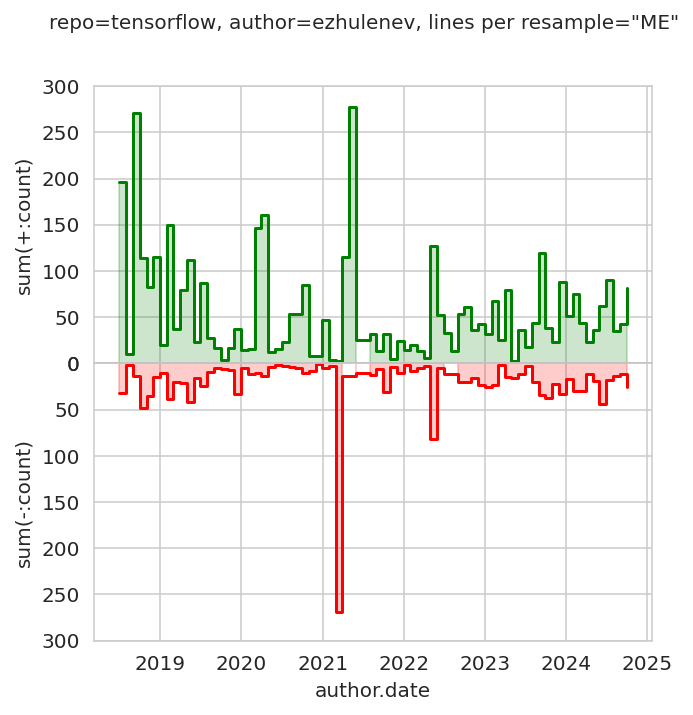

In [67]:
fig = plot_counts(tf_timeline_selected_resampled_df)
pn.pane.Matplotlib(fig, tight=True)

In [68]:
[col[2:] for col in pm_count_cols if col.startswith('+:')]

['count',
 'purpose.data',
 'purpose.documentation',
 'purpose.markup',
 'purpose.other',
 'purpose.programming',
 'purpose.project',
 'purpose.test',
 'type.code',
 'type.data',
 'type.documentation',
 'type.markup',
 'type.other',
 'type.project',
 'type.test']

In [69]:
# NOTE: local variable might have been enough
#prev_max_ylim = None

def plot_pm_col(resampled_df: pd.DataFrame,
                column_base: str = 'type.code', rescale: bool = True,
                repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
                figsize: tuple[float, float] = (5, 5),
):
    sns.set_style("whitegrid")

    p_col = f"+:{column_base}"
    m_col = f"-:{column_base}"
    
    fig = Figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1, sharex=True)

    if p_col not in resampled_df.columns:
        # retrying
        ## DEBUG
        #print(f"(re)running add_pm_count_perc because of missing {p_col!s}")
        resampled_df = add_pm_count_perc(resampled_df)
        
    if p_col not in resampled_df.columns:
        err_msg = f"{p_col!r} not in columns of DataFrame (BUG)"
        print(err_msg)
        
        fig.suptitle(err_msg)
        return fig  # empty figure

    if column_base.endswith(' [%]'):
        max_ylim = 1.05
    elif rescale or getattr(plot_pm_col, 'prev_max_ylim', None) is None:
        max_count = resampled_df[[p_col, m_col]].max().max()
        max_ylim = round_10s(max_count)
        if max_ylim == 0:  # degenerate case
            max_ylim = 10
        plot_pm_col.prev_max_ylim = max_ylim
    else:
        max_ylim = getattr(plot_pm_col, 'prev_max_ylim')

    for ax, column, color, invert in zip(axes.ravel(), [p_col, m_col], ['green', 'red'], [False, True]):
        sns.lineplot(ax=ax, data=resampled_df, 
                     x='author.date', y=column, 
                     color=color, drawstyle='steps-post')
    
        ax.fill_between(resampled_df.index, resampled_df[column],
                        alpha=0.2, color=color, step='post')
        ax.set_ylim(0, max_ylim)
    
        if invert:
            ax.invert_yaxis()
            ax.set_ylabel(f"{agg_func}({column})", loc="bottom", fontsize=9)
        else:
            #ax.set_title(f"author={author_desc}", fontsize=9)
            ax.set_ylabel(f"{agg_func}({column})", loc="top", fontsize=9)
            ax.axhline(0, color="k")

    fig.suptitle(f'repo={repo_desc}, author={author_desc}, lines per resample="{resample_rate}"', fontsize=10)
    fig.subplots_adjust(hspace=0)

    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
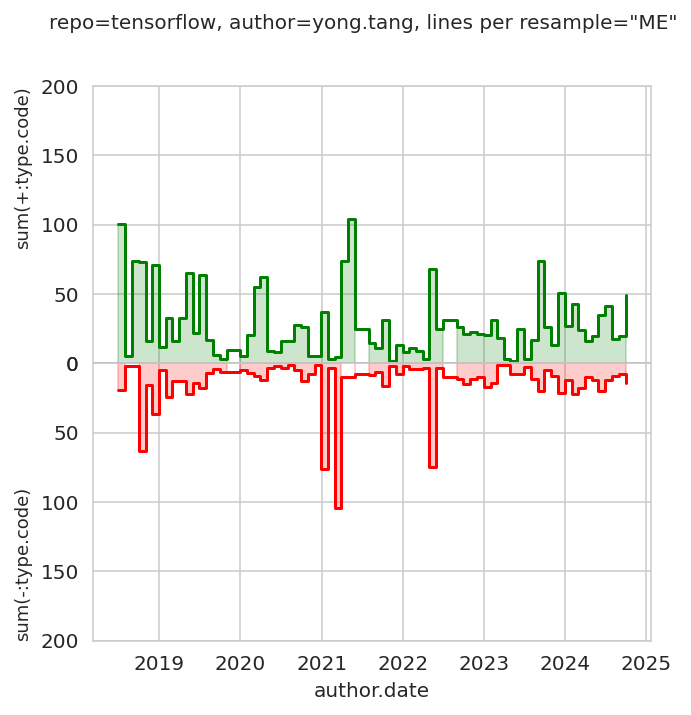

In [70]:
# NOTE: not reactive! widget.value instead of widget.rx()
fig = plot_pm_col(tf_timeline_selected_resampled_df,
                  author_desc=authors_widget.value, resample_rate=resample_rule_widget.value, agg_func=agg_func_widget.value)
pn.pane.Matplotlib(fig, tight=True)

## Patch size and spread, resampled

In [71]:
diff_x_cols

['diff.n_files',
 'diff.hunk_span_src',
 'diff.hunk_span_dst',
 'diff.n_hunks',
 'diff.n_lines_added',
 'diff.n_lines_all',
 'diff.n_add',
 'diff.n_groups',
 'diff.patch_size',
 'diff.hunk_spread_src',
 'diff.hunk_spread_dst',
 'diff.groups_spread',
 'diff.n_lines_removed',
 'diff.n_rem',
 'diff.n_mod',
 'diff.spread_inner',
 'diff.n_binary_files']

In [72]:
tf_timeline_selected_resampled_df.columns

Index(['n_commits', '-:count', '+:count', '-:purpose.data', '+:purpose.data',
       '-:purpose.documentation', '+:purpose.documentation',
       '-:purpose.markup', '+:purpose.markup', '-:purpose.other',
       '+:purpose.other', '-:purpose.programming', '+:purpose.programming',
       '-:purpose.project', '+:purpose.project', '-:purpose.test',
       '+:purpose.test', '-:type.code', '+:type.code', '-:type.data',
       '+:type.data', '-:type.documentation', '+:type.documentation',
       '-:type.markup', '+:type.markup', '-:type.other', '+:type.other',
       '-:type.project', '+:type.project', '-:type.test', '+:type.test',
       'diff.n_files', 'diff.hunk_span_src', 'diff.hunk_span_dst',
       'diff.n_hunks', 'diff.n_lines_added', 'diff.n_lines_all', 'diff.n_add',
       'diff.n_groups', 'diff.patch_size', 'diff.hunk_spread_src',
       'diff.hunk_spread_dst', 'diff.groups_spread', 'diff.n_lines_removed',
       'diff.n_rem', 'diff.n_mod', 'diff.spread_inner', 'diff.n_binary_files

In [73]:
tf_timeline_selected_resampled_df.head(5).index

DatetimeIndex(['2018-06-30 00:00:00+00:00', '2018-07-31 00:00:00+00:00',
               '2018-08-31 00:00:00+00:00', '2018-09-30 00:00:00+00:00',
               '2018-10-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='author.date', freq='ME')

In [74]:
tf_timeline_selected_resampled_df[['diff.n_rem', 'diff.n_mod', 'diff.n_add']].head(5)

,diff.n_rem,diff.n_mod,diff.n_add
author.date,,,
2018-06-30 00:00:00+00:00,7.5,9.0,18.0
2018-07-31 00:00:00+00:00,1.0,1.5,8.0
2018-08-31 00:00:00+00:00,7.0,7.0,148.5
2018-09-30 00:00:00+00:00,29.5,12.5,7.5
2018-10-31 00:00:00+00:00,3.0,4.0,10.0


In [75]:
tf_timeline_selected_resampled_df[['diff.n_rem', 'diff.n_mod', 'diff.n_add']].head(5).values

array([[  7.5,   9. ,  18. ],
       [  1. ,   1.5,   8. ],
       [  7. ,   7. , 148.5],
       [ 29.5,  12.5,   7.5],
       [  3. ,   4. ,  10. ]])

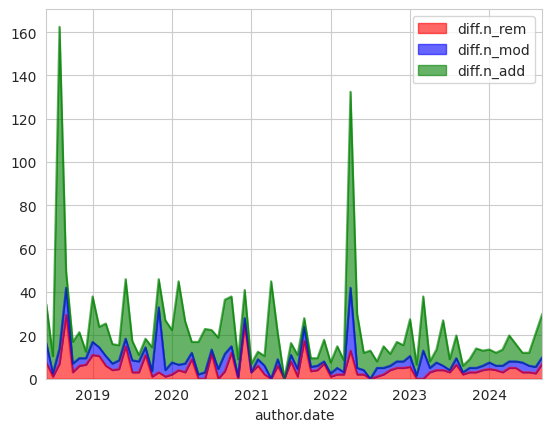

In [76]:
tf_timeline_selected_resampled_df[['diff.n_rem', 'diff.n_mod', 'diff.n_add']].plot.area(color=['r', 'b', 'g'], alpha=0.6);

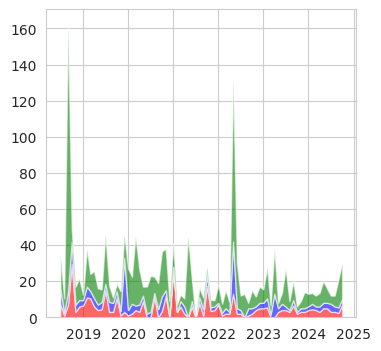

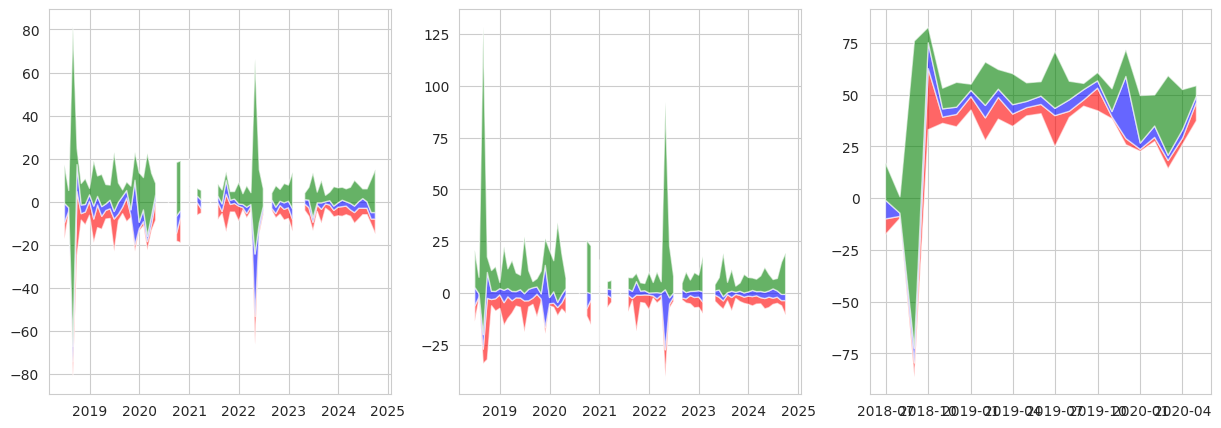

In [77]:
fig, ax = plt.subplots(figsize=(4,4))

ax.stackplot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'].fillna(0),
    tf_timeline_selected_resampled_df['diff.n_mod'].fillna(0),
    tf_timeline_selected_resampled_df['diff.n_add'].fillna(0),
    baseline='zero',
    labels=['rem', 'mod', 'add'],
    colors=['r', 'b', 'g'],
    alpha=0.6,
)

fig, axes = plt.subplots(ncols=3, figsize=(15,5))

axes[0].stackplot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'],
    tf_timeline_selected_resampled_df['diff.n_mod'],
    tf_timeline_selected_resampled_df['diff.n_add'],
    baseline='sym',
    labels=['rem', 'mod', 'add'],
    colors=['r', 'b', 'g'],
    alpha=0.6,
)

axes[1].stackplot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'],
    tf_timeline_selected_resampled_df['diff.n_mod'],
    tf_timeline_selected_resampled_df['diff.n_add'],
    baseline='wiggle',
    labels=['rem', 'mod', 'add'],
    colors=['r', 'b', 'g'],
    alpha=0.6,
)

axes[2].stackplot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'],
    tf_timeline_selected_resampled_df['diff.n_mod'],
    tf_timeline_selected_resampled_df['diff.n_add'],
    baseline='weighted_wiggle',
    labels=['rem', 'mod', 'add'],
    colors=['r', 'b', 'g'],
    alpha=0.6,
)


plt.show()

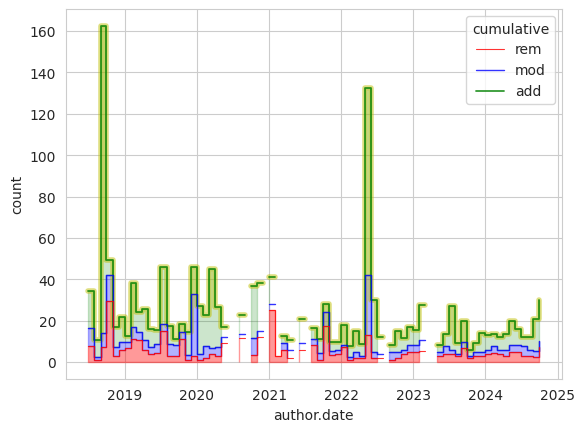

In [78]:
fig, ax = plt.subplots()

ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'],
    color='r',
    alpha=0.4, step='post', interpolate=True,
)
ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'],
    tf_timeline_selected_resampled_df['diff.n_rem'] +
    tf_timeline_selected_resampled_df['diff.n_mod'],
    color='b',
    alpha=0.3, step='post', interpolate=True,
)
ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'] +
    tf_timeline_selected_resampled_df['diff.n_mod'],
    tf_timeline_selected_resampled_df['diff.n_rem'] +
    tf_timeline_selected_resampled_df['diff.n_mod'] +
    tf_timeline_selected_resampled_df['diff.n_add'],
    color='g',
    alpha=0.2, step='post', interpolate=True,
)

ax.plot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'] +
    tf_timeline_selected_resampled_df['diff.n_mod'] +
    tf_timeline_selected_resampled_df['diff.n_add'],
    color='y', lw=4.0, alpha=0.5,
    drawstyle='steps-post',
)
ax.plot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'] +
    tf_timeline_selected_resampled_df['diff.n_mod'] +
    tf_timeline_selected_resampled_df['diff.n_add'],
    color='g', lw=1.3, label='add',
    drawstyle='steps-post', alpha=0.8,
)
ax.plot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'] +
    tf_timeline_selected_resampled_df['diff.n_mod'],
    color='b', lw=1.0, label='mod',
    drawstyle='steps-post', alpha=0.8,
)
ax.plot(
    tf_timeline_selected_resampled_df.index,
    tf_timeline_selected_resampled_df['diff.n_rem'],
    color='r', lw=0.8, label='rem',
    drawstyle='steps-post', alpha=0.8,
)

ax.legend(title='cumulative', reverse=True)
ax.set_xlabel('author.date')
ax.set_ylabel('count')

plt.show();

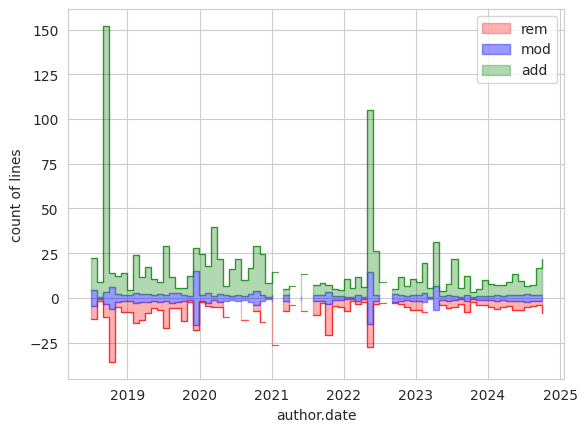

In [79]:
fig, ax = plt.subplots()

ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    -tf_timeline_selected_resampled_df['diff.n_rem'] +
    -0.5*tf_timeline_selected_resampled_df['diff.n_mod'],
    -0.5*tf_timeline_selected_resampled_df['diff.n_mod'],
    color='r', label='rem',
    alpha=0.3, step='post', interpolate=True,
)
ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    -0.5*tf_timeline_selected_resampled_df['diff.n_mod'],
    +0.5*tf_timeline_selected_resampled_df['diff.n_mod'],
    color='b', label='mod',
    alpha=0.4, step='post', interpolate=True,
)
ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    +0.5*tf_timeline_selected_resampled_df['diff.n_mod'],
    +0.5*tf_timeline_selected_resampled_df['diff.n_mod'] +
    tf_timeline_selected_resampled_df['diff.n_add'],
    color='g', label='add',
    alpha=0.3, step='post', interpolate=True,
)

ax.plot(
    tf_timeline_selected_resampled_df.index,
    -tf_timeline_selected_resampled_df['diff.n_rem'] +
    -0.5*tf_timeline_selected_resampled_df['diff.n_mod'],
    color='r', lw=0.9, alpha=0.7, #label='rem',
    drawstyle='steps-post',
)
ax.plot(
    tf_timeline_selected_resampled_df.index,
    +tf_timeline_selected_resampled_df['diff.n_add'] +
    +0.5*tf_timeline_selected_resampled_df['diff.n_mod'],
    color='g', lw=0.9, alpha=0.7, #label='add',
    drawstyle='steps-post',
)
#ax.plot(
#    tf_timeline_selected_resampled_df.index,
#    tf_timeline_selected_resampled_df['diff.n_rem'] +
#    tf_timeline_selected_resampled_df['diff.n_mod'] +
#    tf_timeline_selected_resampled_df['diff.n_add'],
#    color='g', lw=1.3, label='add',
#    drawstyle='steps-post'
#)
#ax.plot(
#    tf_timeline_selected_resampled_df.index,
#    tf_timeline_selected_resampled_df['diff.n_rem'] +
#    tf_timeline_selected_resampled_df['diff.n_mod'],
#    color='b', lw=1.0, label='mod',
#    drawstyle='steps-post'
#)
#ax.plot(
#    tf_timeline_selected_resampled_df.index,
#    tf_timeline_selected_resampled_df['diff.n_rem'],
#    color='r', lw=0.8, label='rem',
#    drawstyle='steps-post'
#)

ax.legend()
ax.set_xlabel('author.date')
ax.set_ylabel('count of lines')

plt.show();

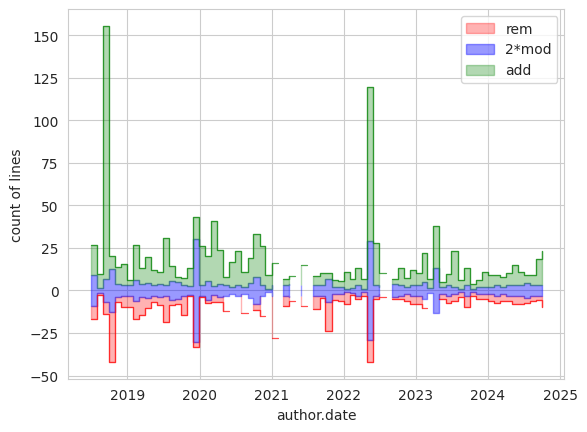

In [80]:
fig, ax = plt.subplots()

ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    -tf_timeline_selected_resampled_df['diff.n_rem'] +
    -tf_timeline_selected_resampled_df['diff.n_mod'],
    -tf_timeline_selected_resampled_df['diff.n_mod'],
    color='r', label='rem',
    alpha=0.3, step='post', interpolate=True,
)
ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    -tf_timeline_selected_resampled_df['diff.n_mod'],
    +tf_timeline_selected_resampled_df['diff.n_mod'],
    color='b', label='2*mod',
    alpha=0.4, step='post', interpolate=True,
)
ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    +tf_timeline_selected_resampled_df['diff.n_mod'],
    +tf_timeline_selected_resampled_df['diff.n_mod'] +
    tf_timeline_selected_resampled_df['diff.n_add'],
    color='g', label='add',
    alpha=0.3, step='post', interpolate=True,
)

ax.plot(
    tf_timeline_selected_resampled_df.index,
    -tf_timeline_selected_resampled_df['diff.n_rem'] +
    -tf_timeline_selected_resampled_df['diff.n_mod'],
    color='r', lw=0.9, alpha=0.7, #label='rem',
    drawstyle='steps-post',
)
ax.plot(
    tf_timeline_selected_resampled_df.index,
    +tf_timeline_selected_resampled_df['diff.n_add'] +
    +tf_timeline_selected_resampled_df['diff.n_mod'],
    color='g', lw=0.9, alpha=0.7, #label='add',
    drawstyle='steps-post',
)
#ax.plot(
#    tf_timeline_selected_resampled_df.index,
#    tf_timeline_selected_resampled_df['diff.n_rem'] +
#    tf_timeline_selected_resampled_df['diff.n_mod'] +
#    tf_timeline_selected_resampled_df['diff.n_add'],
#    color='g', lw=1.3, label='add',
#    drawstyle='steps-post'
#)
#ax.plot(
#    tf_timeline_selected_resampled_df.index,
#    tf_timeline_selected_resampled_df['diff.n_rem'] +
#    tf_timeline_selected_resampled_df['diff.n_mod'],
#    color='b', lw=1.0, label='mod',
#    drawstyle='steps-post'
#)
#ax.plot(
#    tf_timeline_selected_resampled_df.index,
#    tf_timeline_selected_resampled_df['diff.n_rem'],
#    color='r', lw=0.8, label='rem',
#    drawstyle='steps-post'
#)

ax.legend()
ax.set_xlabel('author.date')
ax.set_ylabel('count of lines')

plt.show();

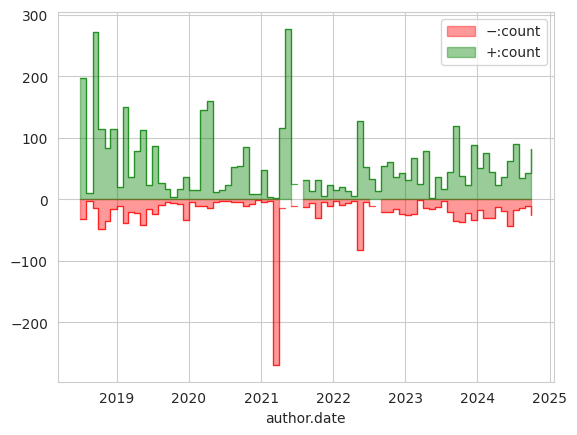

In [81]:
fig, ax = plt.subplots()

ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    -tf_timeline_selected_resampled_df['-:count'],
    color='r', label='−:count',
    alpha=0.4, step='post', interpolate=True,
)
ax.fill_between(
    tf_timeline_selected_resampled_df.index,
    +tf_timeline_selected_resampled_df['+:count'],
    color='g', label='+:count',
    alpha=0.4, step='post', interpolate=True,
)

ax.plot(
    tf_timeline_selected_resampled_df.index,
    -tf_timeline_selected_resampled_df['-:count'],
    color='r', lw=0.9, alpha=0.7, #label='rem',
    drawstyle='steps-post',
)
ax.plot(
    tf_timeline_selected_resampled_df.index,
    +tf_timeline_selected_resampled_df['+:count'],
    color='g', lw=0.9, alpha=0.7, #label='add',
    drawstyle='steps-post',
)

ax.legend()
ax.set_xlabel('author.date')
plt.show();

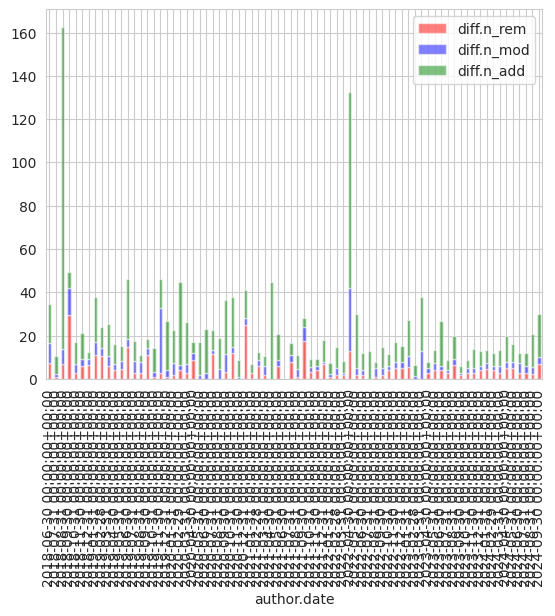

In [82]:
tf_timeline_selected_resampled_df[['diff.n_rem', 'diff.n_mod', 'diff.n_add']].plot.bar(stacked=True, color=['r', 'b', 'g'], alpha=0.5);

In [83]:
tf_timeline_selected_resampled_df[['diff.n_rem', 'diff.n_mod', 'diff.n_add', '-:count', '+:count']].head(5)

,diff.n_rem,diff.n_mod,diff.n_add,-:count,+:count
author.date,,,,,
2018-06-30 00:00:00+00:00,7.5,9.0,18.0,32.0,196.5
2018-07-31 00:00:00+00:00,1.0,1.5,8.0,2.0,10.0
2018-08-31 00:00:00+00:00,7.0,7.0,148.5,14.0,271.5
2018-09-30 00:00:00+00:00,29.5,12.5,7.5,48.0,114.5
2018-10-31 00:00:00+00:00,3.0,4.0,10.0,35.0,83.0


In [84]:
df_test = tf_timeline_selected_resampled_df[['diff.n_rem', 'diff.n_mod', 'diff.n_add', '-:count', '+:count']].copy()
df_test['diff.n_rem + diff.n_mod'] = df_test['diff.n_rem'] + df_test['diff.n_mod']
df_test['diff.n_mod + diff.n_add'] = df_test['diff.n_mod'] + df_test['diff.n_add']

df_test.head(5)

,diff.n_rem,diff.n_mod,diff.n_add,-:count,+:count,diff.n_rem + diff.n_mod,diff.n_mod + diff.n_add
author.date,,,,,,,
2018-06-30 00:00:00+00:00,7.5,9.0,18.0,32.0,196.5,16.5,27.0
2018-07-31 00:00:00+00:00,1.0,1.5,8.0,2.0,10.0,2.5,9.5
2018-08-31 00:00:00+00:00,7.0,7.0,148.5,14.0,271.5,14.0,155.5
2018-09-30 00:00:00+00:00,29.5,12.5,7.5,48.0,114.5,42.0,20.0
2018-10-31 00:00:00+00:00,3.0,4.0,10.0,35.0,83.0,7.0,14.0


In [85]:
df_test_full = tf_timeline_df[['bug_id', 'patch_id', 'n_parents', 'author.date', 'diff.n_rem', 'diff.n_mod', 'diff.n_add', '-:count', '+:count']].copy()
df_test_full['patch_id'] = df_test_full['patch_id'].str[:-5]
df_test_full['rem + mod'] = df_test_full['diff.n_rem'].fillna(0) + df_test_full['diff.n_mod'].fillna(0)
df_test_full['mod + add'] = df_test_full['diff.n_mod'].fillna(0) + df_test_full['diff.n_add'].fillna(0)

df_test_full.head(10)

,bug_id,patch_id,n_parents,author.date,diff.n_rem,diff.n_mod,diff.n_add,-:count,+:count,rem + mod,mod + add
0,yong.tang,cf1429707d68edb22cd861ce900d0ec4600668e5,1.0,2018-05-23 19:06:56+00:00,NaN,NaN,3.0,NaN,3.0,0.0,3.0
1,yong.tang,66803c1fca4d178d6ba8f4c96073efaed8541d59,1.0,2019-08-18 15:53:36+00:00,NaN,NaN,22.0,NaN,22.0,0.0,22.0
2,yong.tang,771a8060e8eea386d75ace3d08794f3b967db564,1.0,2018-07-13 06:04:32+00:00,1.0,NaN,NaN,1.0,NaN,1.0,0.0
3,yong.tang,caf1e0e307efe8746de167dcd0f2b226ac7cbea9,1.0,2022-10-05 15:39:23+00:00,3.0,7.0,1.0,10.0,8.0,10.0,8.0
4,yong.tang,f6940f2195b5f3e017ab5b8618d1a6fd5d6671ac,1.0,2020-07-16 22:13:26+00:00,3.0,1.0,3.0,4.0,4.0,4.0,4.0
5,yong.tang,10396ff82a9216a3ce5c5770eefa85bc0a973d38,1.0,2020-05-03 20:22:18+00:00,NaN,1.0,2.0,1.0,3.0,1.0,3.0
6,yong.tang,454d3e11216bcf44583665d714227cd20f88739b,1.0,2018-08-05 16:07:17+00:00,2.0,NaN,2.0,3.0,2.0,2.0,2.0
7,yong.tang,16a2a9f6bb9bf4421119b591fa56d58ee95c9a0e,1.0,2018-01-26 20:45:35+00:00,20.0,12.0,44.0,48.0,821.0,32.0,56.0
8,yong.tang,87de301db14745ab920d7e32b53d926236a4f2af,1.0,2017-12-27 02:46:17+00:00,24.0,1.0,32.0,58.0,38.0,25.0,33.0
9,yong.tang,7608f48f777873beaacd0ae60876641f8cb12a67,1.0,2022-09-21 21:20:59+00:00,NaN,NaN,10.0,NaN,10.0,0.0,10.0


In [86]:
tf_timeline_data[7]

{'bug_id': 'yong.tang',
 'patch_id': '16a2a9f6bb9bf4421119b591fa56d58ee95c9a0e.json',
 'file_names': 18,
 'language:Python': 5,
 'type:programming': 16,
 'purpose:programming': 9,
 '+:count': 821,
 '+:type.code': 340,
 '+:purpose.programming': 437,
 'language:Starlark': 7,
 'purpose:project': 5,
 '+:type.project': 189,
 '+:purpose.project': 189,
 '-:count': 48,
 '-:type.project': 32,
 '-:purpose.project': 32,
 '-:type.code': 16,
 '-:purpose.programming': 16,
 'language:/dev/null': 1,
 'type:other': 1,
 'purpose:other': 1,
 'language:C++': 3,
 '+:type.documentation': 97,
 'purpose:test': 2,
 '+:type.test': 151,
 '+:purpose.test': 151,
 'language:Shell': 1,
 'language:Diff': 1,
 'type:data': 1,
 'purpose:data': 1,
 '+:type.data': 44,
 '+:purpose.data': 44,
 'author.timestamp': 1516999535,
 'author.tz_info': '-0800',
 'author.name': 'Yong Tang',
 'author.email': 'yong.tang.github@outlook.com',
 'committer.timestamp': 1516999535,
 'committer.tz_info': '-0800',
 'committer.name': 'Rasmus Mu

In [87]:
def plot_split_size(
    resampled_df: pd.DataFrame,
    repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum',
    figsize: tuple[float, float] = (5, 5),
):
    sns.set_style("whitegrid")

    fig = Figure(figsize=figsize)
    #axes = fig.subplots(nrows=2, ncols=1, sharex=True)
    ax = fig.subplots()

    resampled_df.plot.area(
        use_index=True, y=['diff.n_rem', 'diff.n_mod', 'diff.n_add'],
        color=['r', 'b', 'g'], alpha=0.6,
        #drawstyle='steps-post',  # does NOT work!
        ax=ax,
    )

    return fig

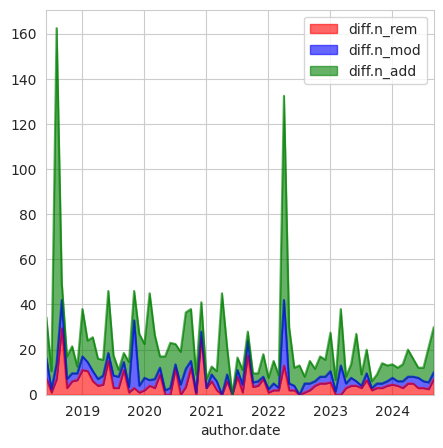

In [88]:
fig = plot_split_size(tf_timeline_selected_resampled_df)
fig

## Bihistogram of +/- lines

In [89]:
def bihist(ax, dataset1, dataset2,
           dataset1_name='dataset1', dataset2_name='dataset2',
           dataset1_color='g', dataset2_color='r',
           bins=None):
    # Plot the first histogram
    ax.hist(dataset1, bins=bins, label=dataset1_name, color=dataset1_color)

    # Plot the second histogram
    # (notice the negative weights, which flip the histogram upside down)
    ax.hist(dataset2, weights=-np.ones_like(dataset2), bins=bins, label=dataset2_name, color=dataset2_color)
    ax.axhline(0, color="k", linewidth=0.2)
    ax.legend()

In [90]:
def plot_bihist(dataset1, dataset2,
                dataset1_name='dataset1', dataset2_name='dataset2',
                dataset1_color='g', dataset2_color='r',
                bin_width=5, max_value=100, figsize=None):
    sns.set_style("whitegrid")

    fig = Figure(figsize=figsize)
    ax = fig.subplots()

    bins = np.arange(0, max_value + bin_width, bin_width)

    bihist(ax,
           dataset1, dataset2,
           dataset1_name, dataset2_name,
           dataset1_color, dataset2_color,
           bins)
    
    return fig

In [91]:
'{pm}:count'.format(pm='+')

'+:count'

In [92]:
def bihist_pm_df(df, column_fmt='{pm}:count', color_plus='g', color_minus='r', agg_func=None,
                 bin_width=5, max_value=100, figsize=None, title=None):
    added_counts_column   = column_fmt.format(pm='+')
    removed_counts_column = column_fmt.format(pm='-')
    added_counts_name   = f"{column_fmt.format(pm='+')}"  # Unicode +
    removed_counts_name = f"{column_fmt.format(pm='−')}"  # Unicode −
    
    added_counts   = df[added_counts_column].values
    removed_counts = df[removed_counts_column].values

    # TODO: automatic max_value if None
    fig = plot_bihist(dataset1=added_counts, dataset2=removed_counts,
                      dataset1_name=added_counts_name, dataset2_name=removed_counts_name,
                      dataset1_color=color_plus, dataset2_color=color_minus,
                      bin_width=bin_width, max_value=max_value, figsize=figsize)

    if title is not None:
        fig.suptitle(title, fontsize=10)

    if agg_func is None:
        fig.supxlabel(column_fmt.format(pm='±'))
    else:
        fig.supxlabel(f"{agg_func}({column_fmt.format(pm='±')})")
    
    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
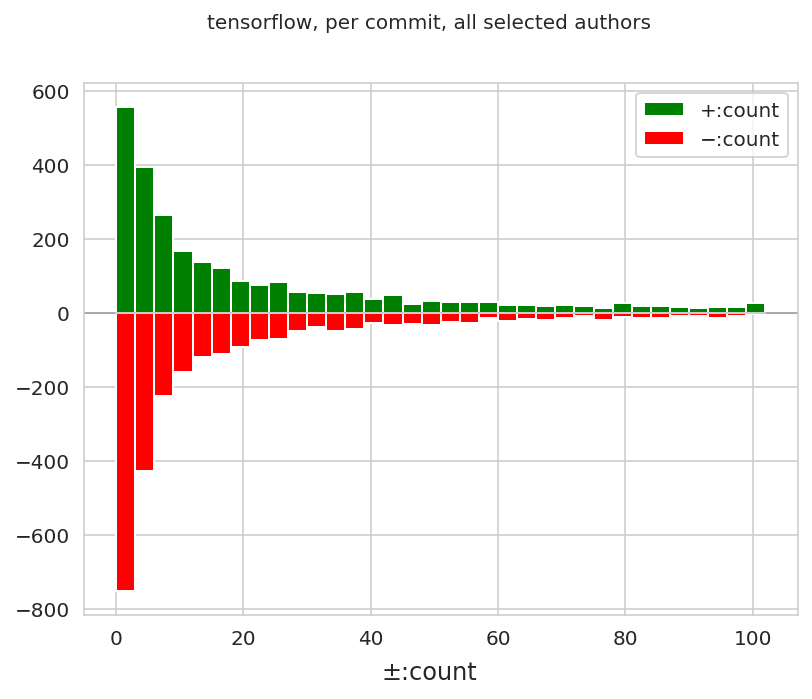

In [93]:
fig = bihist_pm_df(tf_timeline_df, bin_width=3, title='tensorflow, per commit, all selected authors')
pn.pane.Matplotlib(fig, tight=True)

In [94]:
tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value][['+:count', '-:count']].values

array([[  3.,  nan],
       [ 22.,  nan],
       [ nan,   1.],
       ...,
       [ nan, 148.],
       [ 17.,  nan],
       [ 24.,   2.]])

In [95]:
vals = np.nan_to_num(tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value][['+:count', '-:count']].values)
(max(vals.T[0]), max(vals.T[1]))

(np.float64(4865.0), np.float64(9050.0))

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
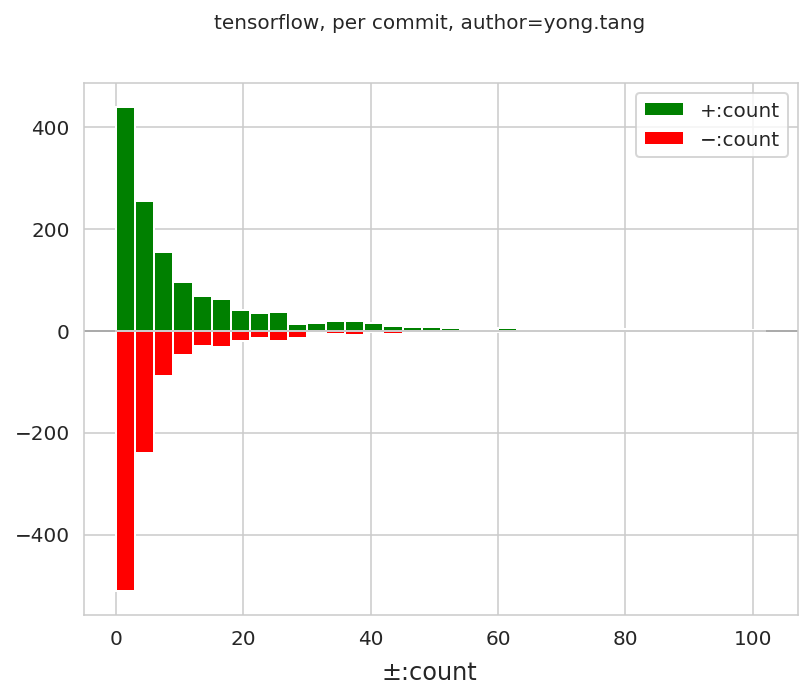

In [96]:
fig = bihist_pm_df(tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value], bin_width=3, max_value=100,
                   title=f'tensorflow, per commit, author={authors_widget.value}')
pn.pane.Matplotlib(fig, tight=True)

In [97]:
agg_func_widget.value

'sum'

In [98]:
authors_widget.value

'yong.tang'

In [99]:
type(authors_widget.value)

str

In [100]:
resample_rule_widget.value

'ME'

In [101]:
tf_timeline_selected_resampled_df = resample_timeline(author=authors_widget.value, resample_rate=resample_rule_widget.value, agg_func='sum')

In [102]:
vals = tf_timeline_selected_resampled_df[['+:count', '-:count']].values
(max(vals.T[0]), max(vals.T[1]))

(np.float64(5491.0), np.float64(9369.0))

In [103]:
tf_timeline_selected_resampled_df[['+:count', '-:count']].head(5)

,+:count,-:count
author.date,,
2017-03-31 00:00:00+00:00,102.0,80.0
2017-04-30 00:00:00+00:00,16.0,7.0
2017-05-31 00:00:00+00:00,256.0,40.0
2017-06-30 00:00:00+00:00,1253.0,170.0
2017-07-31 00:00:00+00:00,191.0,48.0


In [104]:
tf_timeline_df[tf_timeline_df['bug_id'] == authors_widget.value][['author.date', '+:count', '-:count']].sort_values('author.date').head(10)

,author.date,+:count,-:count
812,2017-03-04 22:47:26+00:00,6.0,6.0
160,2017-03-05 19:27:24+00:00,4.0,4.0
754,2017-03-10 03:25:42+00:00,2.0,NaN
822,2017-03-18 13:12:44+00:00,6.0,6.0
1270,2017-03-22 22:44:28+00:00,42.0,NaN
887,2017-03-23 00:51:10+00:00,26.0,NaN
687,2017-03-25 21:03:33+00:00,7.0,55.0
1353,2017-03-26 20:01:55+00:00,9.0,9.0
962,2017-04-10 23:43:06+00:00,14.0,5.0
922,2017-04-29 15:38:24+00:00,2.0,2.0


Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
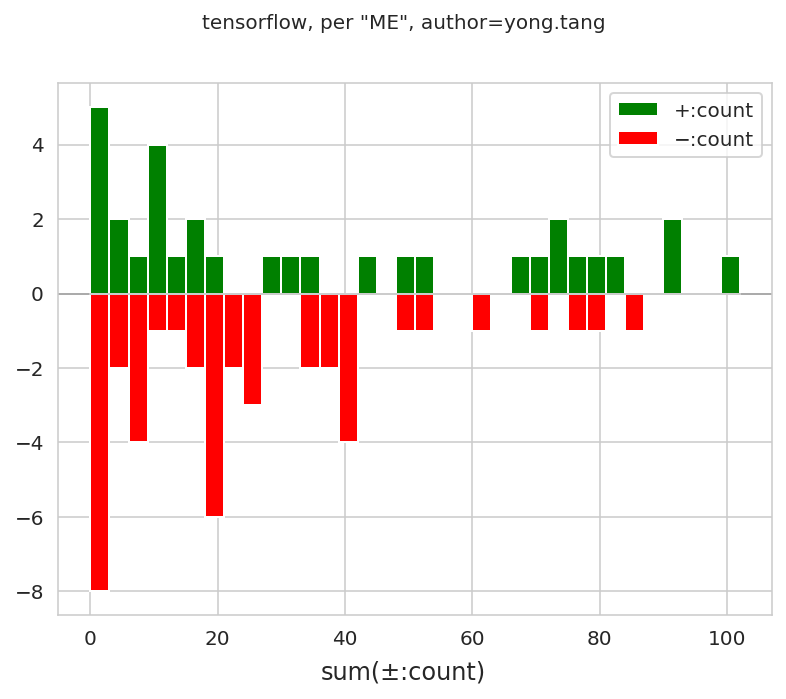

In [105]:
fig = bihist_pm_df(tf_timeline_selected_resampled_df, bin_width=3, agg_func=agg_func_widget.value,
                   title=f'tensorflow, per "{resample_rule_widget.value}", author={authors_widget.value}')
pn.pane.Matplotlib(fig, tight=True)

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
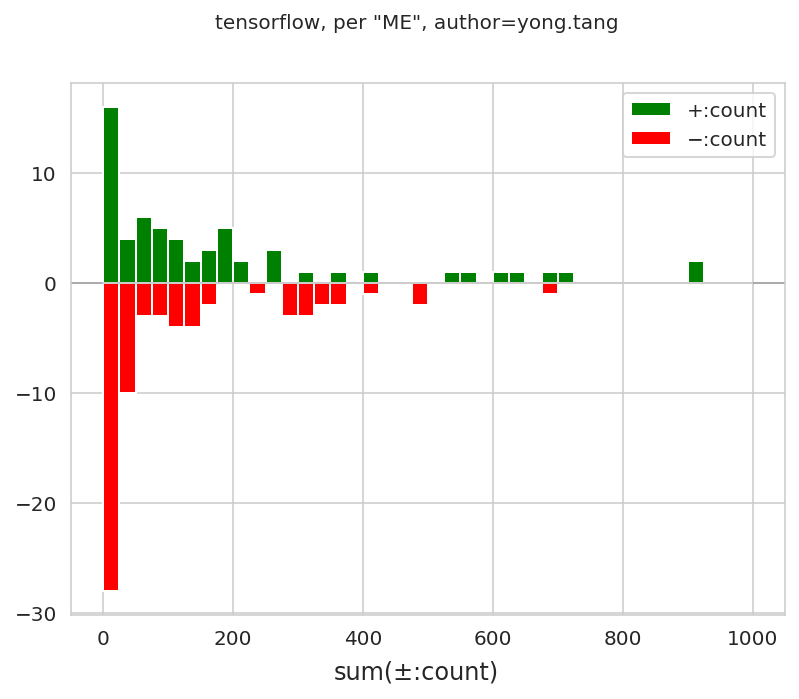

In [106]:
fig = bihist_pm_df(tf_timeline_selected_resampled_df, bin_width=25, max_value=1000, agg_func=agg_func_widget.value,
                   title=f'tensorflow, per "{resample_rule_widget.value}", author={authors_widget.value}')
pn.pane.Matplotlib(fig, tight=True)

## Commits, resampled

In [107]:
def plot_commits(resampled_df: pd.DataFrame,
                 repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev',
                 resample_rate: str = 'ME',
                 figsize: tuple[float, float] = (5, 5)
):
    
    sns.set_style("whitegrid")

    fig = Figure(figsize=figsize)
    ax = fig.subplots()

    sns.lineplot(ax=ax, data=resampled_df, 
                 x='author.date', y='n_commits',
                 color='blue', drawstyle='steps-post')
    
    ax.fill_between(resampled_df.index, resampled_df['n_commits'],
                    alpha=0.2, color='blue', step='post')
    #ax.set_ylim(0, 120)
    ax.set_ylabel(f"commits")
    #ax.set_xlim(datetime.date(2017, 3, 31), datetime.date(2024, 9, 30))
    ax.set_title(f"author={author_desc}", fontsize=9)

    fig.suptitle(f'repo={repo_desc}, count of commits, resample="{resample_rate}"', fontsize=10)

    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
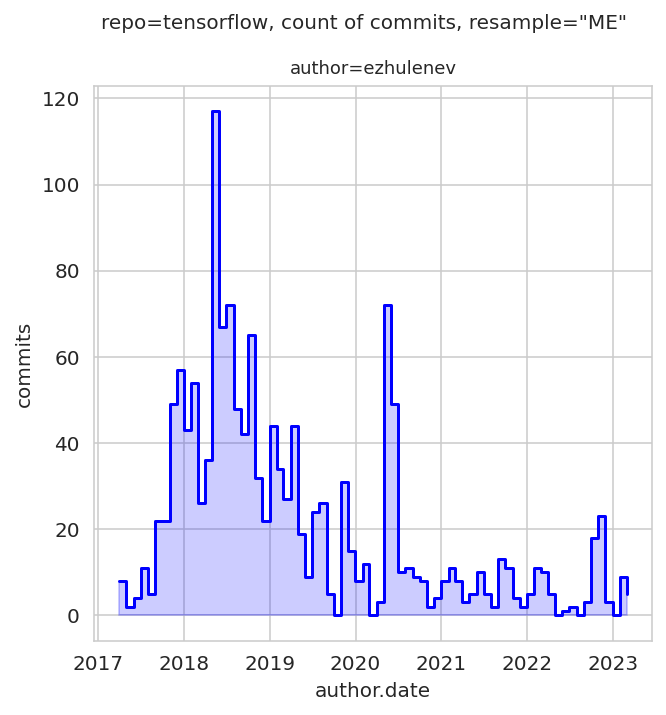

In [108]:
fig = plot_commits(tf_timeline_selected_resampled_df)
pn.pane.Matplotlib(fig, tight=True)

## Heatmap: time vs line type

In [109]:
from matplotlib.colors import LogNorm, Normalize

In [110]:
cols_plus_all  = [f"+:type.{type}" for type in ['code', 'documentation', 'test', 'other', 'data', 'markup', 'project']]
cols_minus_all = [f"-:type.{type}" for type in ['code', 'documentation', 'test', 'other', 'data', 'markup', 'project']]

In [111]:
def plot_heatmap(resampled_df: pd.DataFrame,
                 repo_desc: str = 'tensorflow', author_desc: str = 'ezhulenev',
                 resample_rate: str = 'ME', agg_func: str = 'sum',
                 figsize: tuple[float, float] = (16,3.3),
):
    for c in cols_plus_all:
        if c not in resampled_df.columns:
            resampled_df[c] = 0

    for c in cols_minus_all:
        if c not in resampled_df.columns:
            resampled_df[c] = 0

    resampled_df = resampled_df.set_index('author.date(Y-m)')
    
    sns.set_style("whitegrid")

    fig = Figure(figsize=figsize)
    axes = fig.subplots(nrows=2, ncols=1, sharex='col')

    sns.heatmap(resampled_df[cols_plus_all].transpose(),
                square=True, cmap='Greens', vmin=0, vmax=15000,
                xticklabels=5, norm=LogNorm(),
                ax=axes[1])
    axes[0].get_xaxis().set_visible(False)

    sns.heatmap(resampled_df[reversed(cols_minus_all)].transpose(),
                square=True, cmap='Reds', vmin=0, vmax=15000,
                xticklabels=5, norm=LogNorm(),
                ax=axes[0])

    fig.suptitle(f'repo={repo_desc}, author={author_desc}, resample="{resample_rate}", agg_func={agg_func!r}', fontsize=10)
    #fig.subplots_adjust(hspace=-0.2)

    return fig

Matplotlib(Figure, design=<class 'panel.theme.materi..., height=250, tight=True)
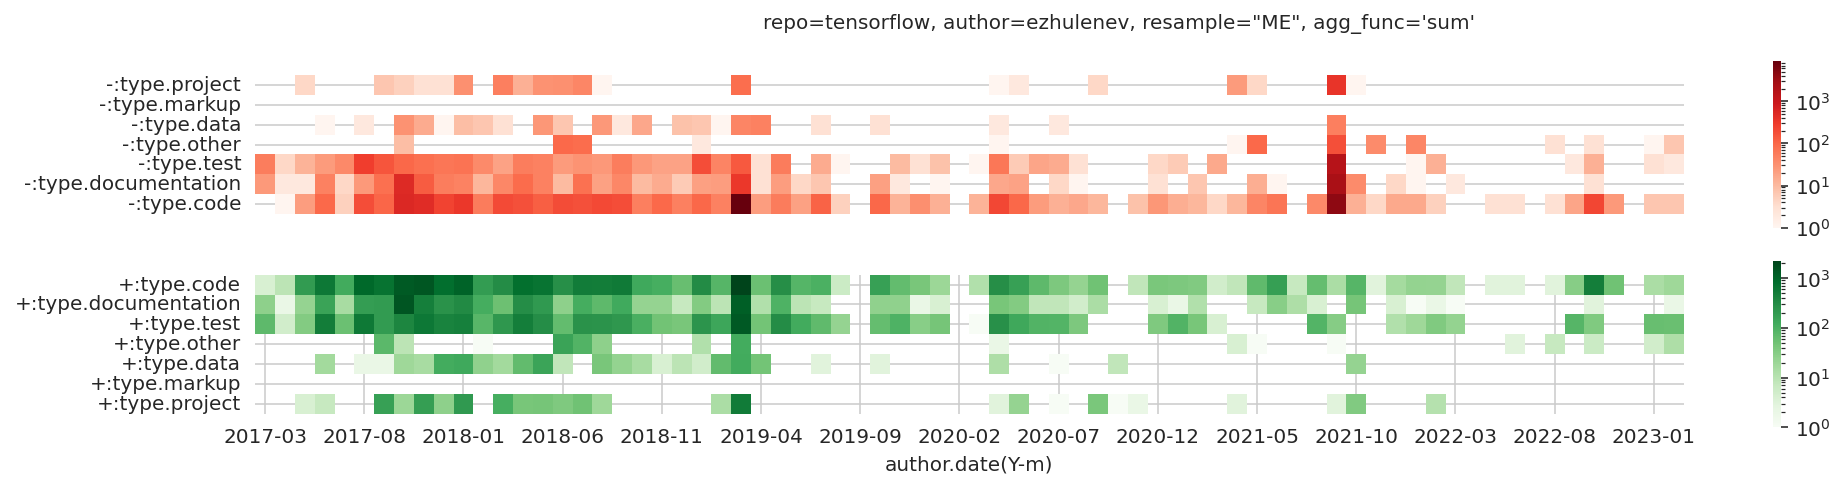

In [112]:
fig = plot_heatmap(tf_timeline_selected_resampled_df)
pn.pane.Matplotlib(fig, tight=True, height=250)

# Bind plots to widgets

In [113]:
def resample_and_plot_counts(repo: str = 'tensorflow', author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum', figsize = (5,5)):
    ## DEBUG
    #print("resample_and_plot_counts()")
    resampled_df = resample_timeline(author, resample_rate=resample_rate, agg_func=agg_func)
    return plot_counts(resampled_df, repo_desc=repo, author_desc=author, resample_rate=resample_rate, agg_func=agg_func, figsize=figsize)

def resample_and_plot_commits(repo: str = 'tensorflow', author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum', figsize = (5,5)):
    ## DEBUG
    #print("resample_and_plot_commits()")
    resampled_df = resample_timeline(author, resample_rate=resample_rate, agg_func=agg_func)
    return plot_commits(resampled_df, repo_desc=repo, author_desc=author, resample_rate=resample_rate, figsize=figsize)

def resample_and_plot_heatmap(repo: str = 'tensorflow', author: str = 'ezhulenev', resample_rate: str = 'ME', agg_func: str = 'sum'):
    ## DEBUG
    #print("resample_and_plot_heatmap()")
    resampled_df = resample_timeline(author, resample_rate=resample_rate, agg_func=agg_func)
    return plot_heatmap(resampled_df, repo_desc=repo, author_desc=author, resample_rate=resample_rate, agg_func=agg_func)

+/- timeline

In [114]:
bound_pm_plot = pn.bind(
    resample_and_plot_counts, repo='tensorflow', author=authors_widget, resample_rate=resample_rule_widget, agg_func=agg_func_widget,
    figsize=(figsize_x_slider.value, figsize_y_slider.value),
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')
        [2] Select(design=<class 'panel.theme.materi..., name='aggregation function', options=['sum', 'mean', ...], value='sum')
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
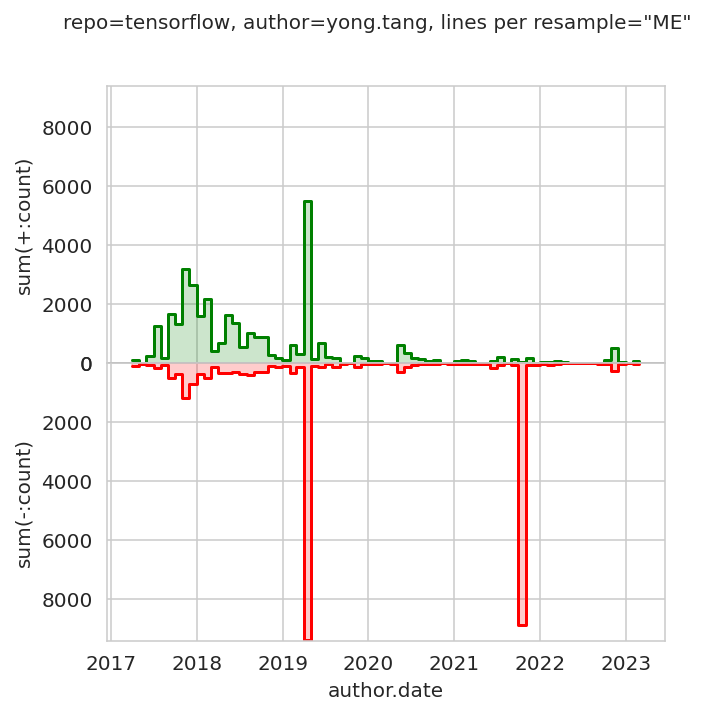

In [115]:
widgets = pn.Column(authors_widget, resample_rule_widget, agg_func_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_pm_plot, tight=True))

In [116]:
bound_commits_plot = pn.bind(
    resample_and_plot_commits, repo='tensorflow', author=authors_widget, resample_rate=resample_rule_widget,
    figsize=(figsize_x_slider.value, figsize_y_slider.value),
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
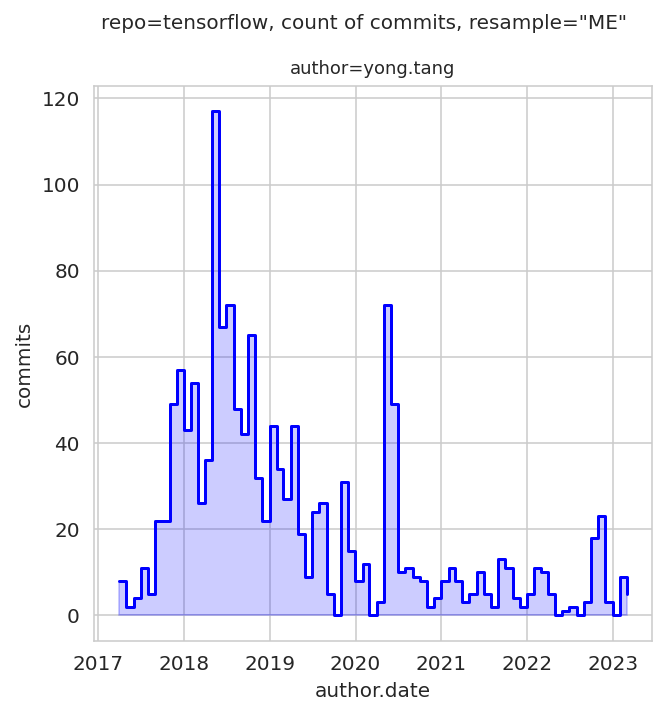

In [117]:
widgets = pn.Column(authors_widget, resample_rule_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_commits_plot, tight=True))

In [118]:
bound_heatmap_plot = pn.bind(
    resample_and_plot_heatmap, repo='tensorflow', author=authors_widget, resample_rate='ME', agg_func=agg_func_widget,
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., height=250, sizing_mode='fixed', tight=True)
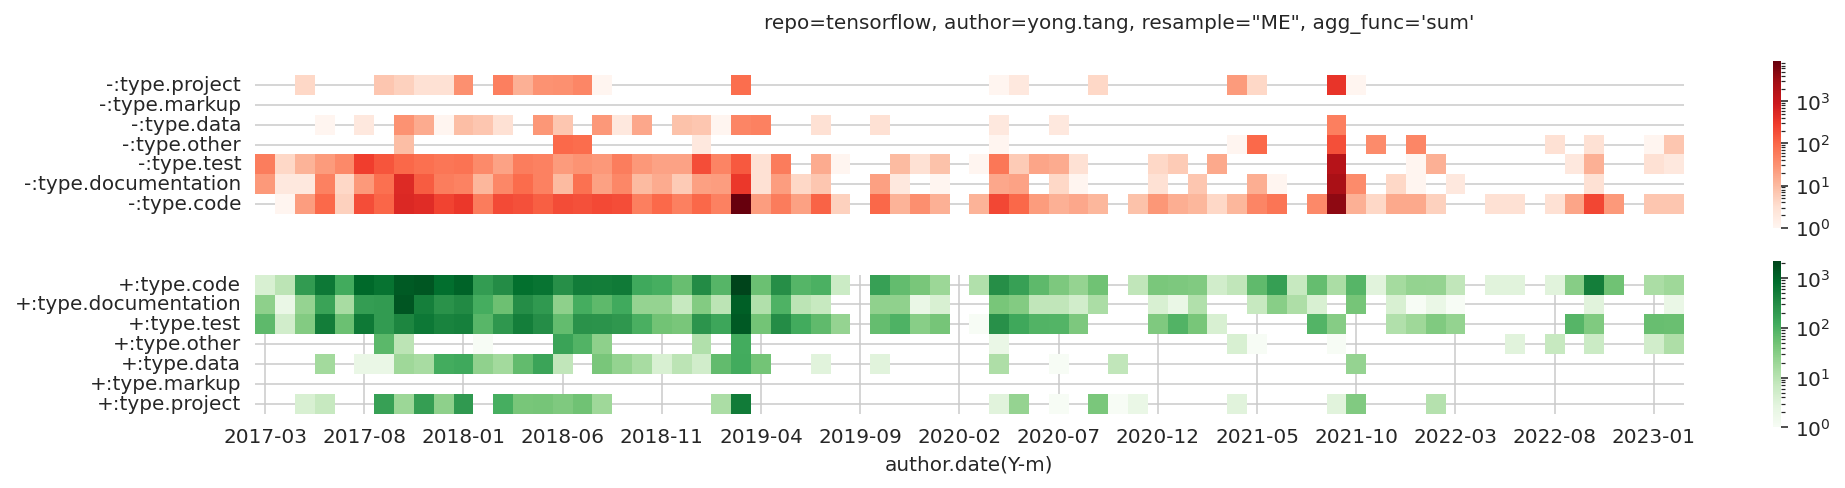

In [119]:
widgets = pn.Column(authors_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_heatmap_plot, tight=True, sizing_mode="fixed", height=250))

In [120]:
@pn.cache
def tf_timeline_df_author(author: str = 'ezhulenev'):
    return tf_timeline_df[tf_timeline_df['bug_id'] == author]

@pn.cache
def hist_all_title(author: str = 'ezhulenev'):
    return f'tensorflow, per commit, author={author}' 


bound_timeline_df_author = pn.bind(
    tf_timeline_df_author, authors_widget,
)

bound_hist_all_title = pn.bind(
    hist_all_title, authors_widget,
)


bound_hist_all_plot = pn.bind(
    bihist_pm_df,
    bound_timeline_df_author,
    bin_width=bin_width_widget.param.value_throttled, max_value=max_value_widget.param.value_throttled,
    title=bound_hist_all_title,
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] WidgetBox(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] EditableIntSlider(design=<class 'panel.theme.materi..., end=25, fixed_start=1, margin=(-5, 10), name='bin width', start=1, value=3, width=300)
            [2] EditableIntSlider(design=<class 'panel.theme.materi..., end=500, fixed_start=1, margin=(-2, 10), name='max value', start=10, step=5, value=100, width=300)
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
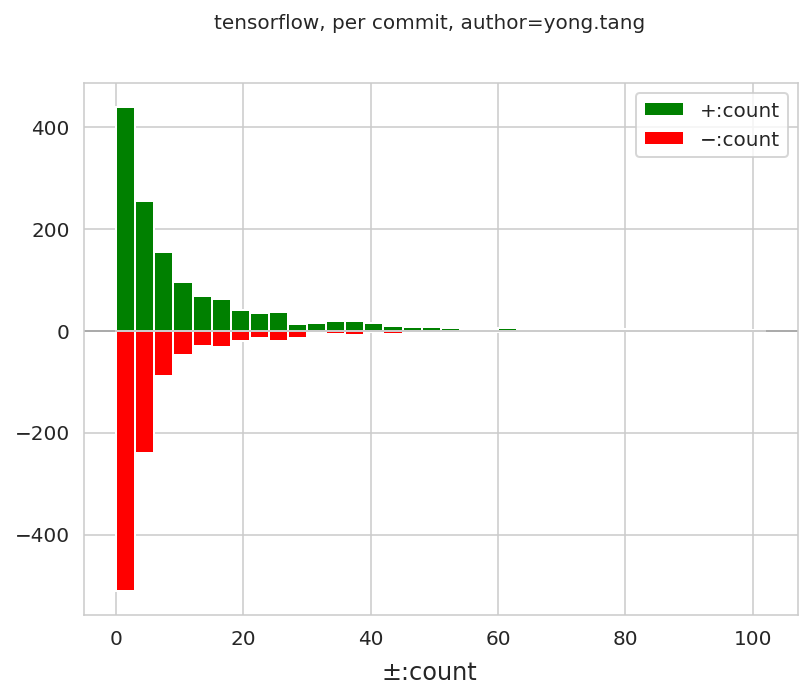

In [121]:
widgets = pn.Column(authors_widget, hist_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_hist_all_plot, tight=True))

In [122]:
@pn.cache
def hist_resampled_title(author: str = 'ezhulenev', resample_rule: str = 'ME'):
    return f'tensorflow, per "{resample_rule}", author={author}'

bound_hist_resampled_title = pn.bind(
    # NOTE: hist_resampled_title() does not have `repo` parameter, always uses 'tensorflow'
    hist_resampled_title, 
    author=authors_widget, resample_rule=resample_rule_widget
)

bound_resample_timeline = pn.bind(
    # NOTE: resample_timeline() does not have `repo` parameter
    resample_timeline, 
    author=authors_widget, resample_rate=resample_rule_widget, agg_func=agg_func_widget,
)

bound_hist_resampled_plot = pn.bind(
    bihist_pm_df,
    bound_resample_timeline,
    bin_width=bin_width_widget.param.value_throttled, max_value=max_value_widget.param.value_throttled,
    agg_func=agg_func_widget,
    title=bound_hist_resampled_title,
)

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')
        [2] Select(design=<class 'panel.theme.materi..., name='aggregation function', options=['sum', 'mean', ...], value='sum')
        [3] WidgetBox(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] EditableIntSlider(design=<class 'panel.theme.materi..., end=25, fixed_start=1, margin=(-5, 10), name='bin width', start=1, value=3, width=300)
            [2] EditableIntSlider(design=<class 'panel.theme.materi..., end=500, fixed_start=1, margin=(-2, 10), name='max value', start=10, step=5, value=100, width=300)
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
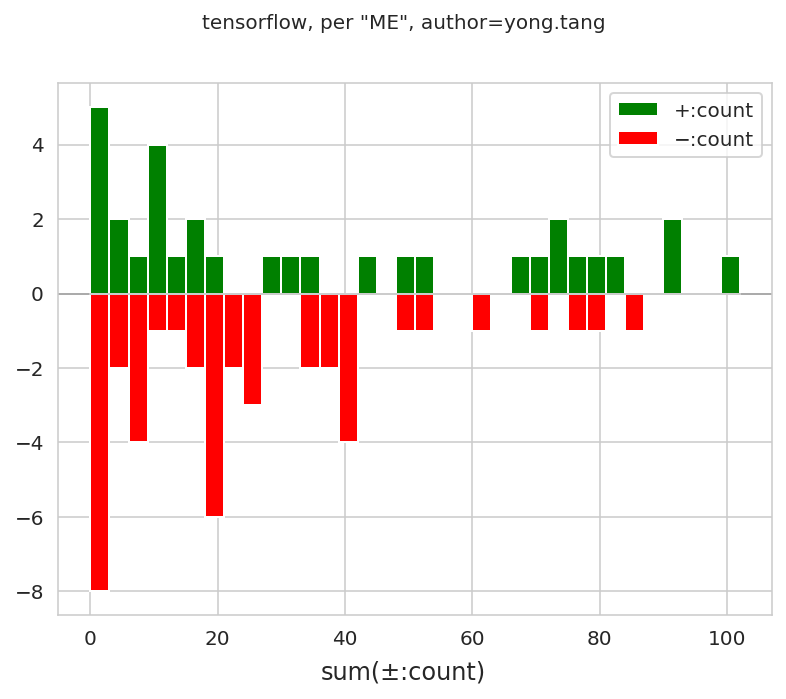

In [123]:
widgets = pn.Column(authors_widget, resample_rule_widget, agg_func_widget, hist_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_hist_resampled_plot, tight=True))

In [124]:
bound_add_pm_count_perc = pn.bind(
    add_pm_count_perc,
    resampled_df=bound_resample_timeline,  # BUG: must be widget, does not create [%] columns???
)

In [125]:
bound_plot_pm_col = pn.bind(
    # function
    plot_pm_col,
    # parameters
    #resampled_df=bound_add_pm_count_perc,  # NOTE: resample_timeline() does not have `repo` parameter
    resampled_df=bound_resample_timeline,
    column_base=column_base_widget,
    rescale=autoscale_widget,
    repo_desc=repos_widget,
    author_desc=authors_widget,
    resample_rate=resample_rule_widget,
    agg_func=agg_func_widget,
)

In [126]:
hex(id(tf_timeline_selected_resampled_df))

'0x7fefb72213a0'

Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi..., sizing_mode='fixed', width=300)
        [0] Select(design=<class 'panel.theme.materi..., name='author', options=['yong.tang', ...], value='yong.tang')
        [1] Select(design=<class 'panel.theme.materi..., name='frequency', options={'calendar day frequency':...}, value='ME')
        [2] Select(design=<class 'panel.theme.materi..., name='aggregation function', options=['sum', 'mean', ...], value='sum')
        [3] Row(design=<class 'panel.theme.materi...)
            [0] FlexBox(align_items='baseline', design=<class 'panel.theme.materi..., objects=[Select(design=<class 'pan...], sizing_mode='stretch_width')
    [1] Matplotlib(Figure, design=<class 'panel.theme.materi..., tight=True)
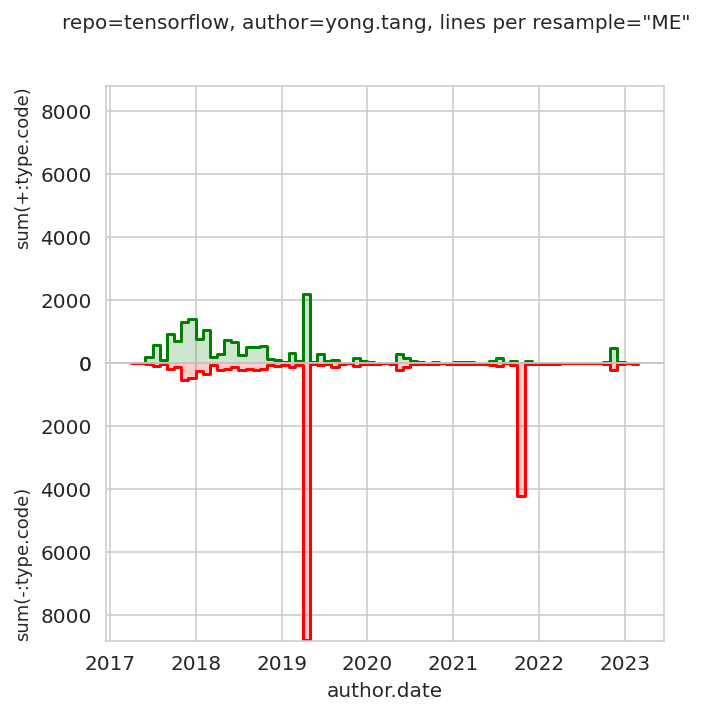

In [127]:
widgets = pn.Column(authors_widget, resample_rule_widget, agg_func_widget, pm_col_widget, sizing_mode="fixed", width=300)
pn.Row(widgets, pn.pane.Matplotlib(bound_plot_pm_col, tight=True))

# Serving the Notebook

Sync widgets and URL, based on https://panel.holoviz.org/how_to/state/examples/sync_url.html

In [128]:
if pn.state.location:
    pn.state.location.sync(repos_widget, {'value': 'repo'})
    pn.state.location.sync(authors_widget, {'value': 'author'})
    pn.state.location.sync(resample_rule_widget, {'value': 'resample'})
    pn.state.location.sync(agg_func_widget, {'value': 'agg_func'})
    pn.state.location.sync(column_base_widget, {'value': 'column'})
    pn.state.location.sync(autoscale_widget, {'value': 'autoscale'})

Note that only some state is saved in query parameters (at least for now).

Extract some common code to avoid repetition

In [129]:
def mpl_card(fig, header):
    return pn.Card(
        pn.pane.Matplotlib(
            fig, 
            tight=True,
            format=plot_format.rx(),
            fixed_aspect=False,
            sizing_mode='fixed',
            width= plot_width.rx(),
            height=plot_width.rx(),
            styles={
                "margin-left":  "auto",
                "margin-right": "auto",
            },
        ),
        header=header,
    )

In [130]:
pn.template.MaterialTemplate(
    site="diffannotator",
    title=f"Examining timeline of {repos_widget.value!r} repository",  # TODO: change to bound function when repo could change
    #sidebar_width=sidebar_width.rx(),  # does not work!
    sidebar_width=350,
    sidebar=[
        repos_widget,  # disabled, and UNBOUND!
        authors_widget,
        #authors_radio_box,
        resample_rule_widget,
        agg_func_widget,
        pm_col_widget,
        hist_widget,
        pn.layout.VSpacer(),
        #pn.Spacer(height=100),
        figsize_widget,
        plot_sizing_mode,
        plot_width,
        plot_format,
    ],
    main=[
        pn.FlexBox(
            mpl_card(bound_pm_plot, "line counts"),
            mpl_card(bound_plot_pm_col, "line-type / file-purpose counts"),  # TODO: should it be here, in this order?s
            mpl_card(bound_commits_plot, "commit counts"),
            mpl_card(bound_hist_all_plot, "histogram of -/+ counts per commit"),
            mpl_card(bound_hist_resampled_plot, "histogram of -/+ counts per resample period"),
            pn.Card(
                pn.pane.Matplotlib(
                    bound_heatmap_plot, 
                    tight=True,
                    format=plot_format.rx(),
                    sizing_mode='fixed',
                    # {{{ start of different values of parameters
                    fixed_aspect=True,
                    width=plot_width.rx()*2,
                    height=plot_width.rx()*1,
                    # }}} end of different parameters
                    styles={
                        "margin-left":  "auto",
                        "margin-right": "auto",
                    },
                ),
                header="heatmap: line-types",
            ),
        ),
    ],
).servable(); # The ; is needed in the notebook to not display the template. Its not needed in a script